### Прогнозирование стоимости жилья


Объективная оценка стоимости недвижимого имущества необходима при:

­ операциях купли-продажи или сдачи в аренду;

­ акционировании предприятий и перераспределении имущественных долей;

­ кадастровой оценке для налогообложения;

­ страховании;

­ кредитовании под залог объектов недвижимости;

­ исполнении права наследования, судебного приговора;

и других операциях, связанных с реализацией имущественных прав на объекты недвижимости.

Нужно искать способы точной оценки, как со стороны продавца, так и со стороны покупателя. Поэтому крайне важно независимое, быстрое и точное знание о ценах на рынке жилой недвижимости.

загрузим библиотеки

In [243]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re


from scipy.stats import ttest_ind
from itertools import combinations
from collections import Counter

from datetime import datetime
import xlrd, xlwt
import re 
import warnings

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

#from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.feature_selection import f_classif, mutual_info_classif, f_regression
from sklearn import metrics #
# инструмент для разделения датасета:
from sklearn import model_selection, preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

#Готовим подвыборки
from sklearn.model_selection import train_test_split
random_seed = 42
#Подгружаем RMSLE
from sklearn.metrics import mean_squared_log_error

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score

warnings.filterwarnings('ignore')

%matplotlib inline

увеличим количество отображения строк и загрузим датасет

In [244]:
pd.set_option('display.max_rows', 80)  # показывать больше строк
pd.set_option('display.max_columns', 80)  # показывать больше колонок
#открываем файл
data = pd.read_csv('final_data.csv')

In [4]:
#Функции
# Наличие выбросов
def outliers(column):
    outlier1 = outlier2 = 0
    """ 
    Функция проверяет наличие выбросов через межквартильный размах
    """
    q1 = data[column].quantile(q=0.25, interpolation='midpoint')
    q3 = data[column].quantile(q=0.75, interpolation='midpoint')
    MR = round(q3 - q1, 1)
    limit1 = q1 - 1.5 * MR
    limit2 = q3 + 1.5 * MR
    if data[column].min() < limit1:
        print(f'выбросы ниже {limit1}')
    elif data[column].max() > limit2:
        print(f'выбросы выше {limit2}')
    else:
        print('выбросов нет')
    return

# Визуализация признаков
def graf_cat(col):
    fig, (ax2) = plt.subplots(
        nrows=1, ncols=1,
        figsize=(12, 6)
    )

    sns.boxplot(col, "log_price", data=data, ax=ax2)

    ax2.set_title(f'Зависимость логарифма цены от {col}')
    ax2.set_xlabel(f'значения {col}')
    ax2.set_ylabel('логарифм цены')
    plt.show()
    
# Построение гистограммы
def gistogramma(col):
    fig, (ax1) = plt.subplots(
    nrows=1, ncols=1,
)

    ax1.hist(data[col], bins=77)
    ax1.set_title(f'Гистограмма {col}')
    ax1.set_xlabel(f'знечения {col}')
    ax1.set_ylabel('количество значений')


    plt.show
    
#Функция проверяет статистически значимые различия колонок
def get_stat_dif(column):

    cols = data.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'log_price'],
                     data.loc[data.loc[:, column] == comb[1], 'log_price']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
            
# Функция для определения метрик моделей           
def print_regression_metrics(Ytest, y_pred):
    mse = mean_squared_error(Ytest, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

Посмотрим какие данные в датасете

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [5]:
#Проверим на наличие дубликатов
data.duplicated().value_counts()

False    377135
True         50
dtype: int64

In [245]:
#Удалим их и проверим данные
data.drop_duplicates(inplace=True)
display(data.shape)

(377135, 18)

Данные содержат 18 признаков и 377135 элементов. Данные можно разделить на:

numerical_columns = ['baths', 'sqft', 'beds', 'stories', 'mls-id', 'MlsId', 'target']

binary_columns = ['private pool', 'PrivatePool']

categorial_columns = ['status', 'propertyType', 'street', 'fireplace', 'city', 'zipcode', 'state', 'homeFacts', 'schools']

Построим тепловую карту пропущенных значний

<AxesSubplot:>

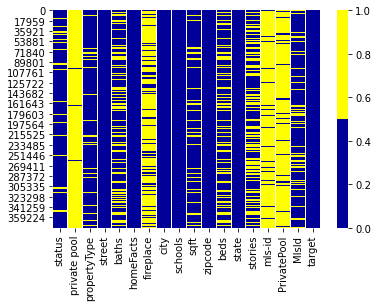

In [7]:
cols = data.columns[:]
colours = ['#000099', '#ffff00'] # желтый цвет - пропущенные значения
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours))

Больше всего пропущенных значений в признаках: private pool, fireplace, mls-id, PrivatePool. Наличие собственного бассейна содержится в 2 признаках - можно их объединить, а в случае когда нет данных по наличию бассейна или камина -  трактовать как их отсутствие. 
В стоимости жилья также есть пропущенные значения. удалим эти данные

In [8]:
#Проверим наличие пропущенных значений в стоимости жилья и удалим их (данные не подходят для модели)
data.target.isna().value_counts()

False    374655
True       2480
Name: target, dtype: int64

In [246]:
data.dropna(subset = ['target'], inplace=True)
display(data.shape)

(374655, 18)

### Предобработка данных

#### pool&private_pool

In [10]:
# количество значений когда есть данные 
len(data[data.PrivatePool.isna() != True])

40120

In [11]:
data['private pool'].value_counts()

Yes    4151
Name: private pool, dtype: int64

In [247]:
# объединим данные о наличии бассейна в признак Pool
data['private pool'] = data['private pool'].fillna('0')
data['PrivatePool'] = data['PrivatePool'].fillna('0')
data['private pool'] = data['private pool'].apply(lambda x: x.lower())
data['private pool'] = data['private pool'].apply(lambda x: x.replace('yes', '1'))
data['private pool'] = data['private pool'].astype('int')
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: x.lower())
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: x.replace('yes', '1'))
data['PrivatePool'] = data['PrivatePool'].astype('int')
data['Pool'] = data.PrivatePool + data['private pool']

In [13]:
data.Pool.value_counts()

0    330384
1     44271
Name: Pool, dtype: int64

Значит информация не дублировалась и можно удалить исходные признаки

In [248]:
column_to_del = ['private pool', 'PrivatePool']

#### street

In [249]:
# Приведем к однообразию адрес
data.street = data.street.fillna('unknown address')
data.street = data.street.apply(lambda x: x.lower())
data.street = data.street.apply(lambda x: x.replace('address not disclosed', 'unknown address').replace('(undisclosed address)', 'unknown address').replace('undisclosed address', 'unknown address').replace('address not available', 'unknown address'))

#### beds& sqft

In [250]:
# Рассмотрим признак количество спален и заменим на наиболее частое
data['beds'] = data['beds'].fillna('3')
data.beds = data.beds.astype(str).apply(lambda x: x.replace(' Beds', '').replace(' bd', '').replace('--', '0').replace('.0', ''))
data.beds = data.beds.astype(str).apply(lambda x: x.replace('Baths', '3').replace('Bath', '3'))

In [17]:
data.beds.value_counts().tail(10)

10.2 acres     1
3,325 sqft     1
8.25 acres     1
5.92 acres     1
10,079 sqft    1
5,183 sqft     1
5.8 acres      1
7,679 sqft     1
8,058 sqft     1
10.4 acres     1
Name: beds, dtype: int64

Исправим ошибочно записанные данные площади в beds

In [251]:
#отметим пропущенные значения
data['sqft'] = data['sqft'].fillna('empty')

In [252]:
# перепишем в test2 значения площади в sqft и объединим с исходным признаком sqft(создав sqft2)
data['test2'] = data['beds'].apply(lambda x: x if 'sqft' in x else 'empty')
x = data[data.ne('empty')]
data['sqft2'] = x['test2'].combine_first(x['sqft'])

In [253]:
# площадь в arces из признака beds запишем в test2, переведем в sqft и округлим
data['test2'] = data['beds'].apply(lambda x: x if 'acre'in x else '0')
data['test2'] = data.test2.apply(lambda x: x.replace('acres', '').replace('acre', ''))
data['test2'] = data['test2'].astype(float)
data['test2'] *= 43560
data.test2 = data.test2.apply(lambda x: round(x))

In [254]:
#объединим с предыдущим sqft2
data['test2'] = data.test2.apply(lambda x: 'empty' if x == 0 else x)
x = data[data.ne('empty')]
data['sqft2'] = x['test2'].combine_first(x['sqft2'])

In [255]:
#test2 нам больше не нужен
column_to_del.append('test2')

In [23]:
#Приверим правильность действий
data[data.beds == '1 acre'].sample()


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Pool,test2,sqft2
361043,NaN,0,NaN,18104 1st st,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Orlando,"[{'rating': ['8/10', '3/10', '5/10'], 'data': ...",empty,32833,1 acre,FL,NaN,NaN,0,O5753018,"$41,700",0,43560,43560


In [256]:
# Приведем к числовому формату
data.sqft2 = data.sqft2.apply(lambda x: str(x).replace(' sqft', '').replace('--', '1200').replace(',', '').replace('Total interior livable area: ', '').replace('610-840', '725').replace('nan', '1200'))
data.sqft = data.sqft2.apply(lambda x: int(x))

In [257]:
#Удалим ненужный признак
column_to_del.append('sqft2')

Стоит отметить что площадь дома нулевая - значит отсутствие данных. И стоит найти способ замены на число: можно попробовать через связь с количеством спален

In [258]:
data['beds2'] = data['beds'].apply(lambda x: 'Nan' if 'sqft' in x else('Nan' if 'acre' in x else x))
data['beds2'] = data['beds2'].apply(lambda x: x if x.isnumeric() == True else 'Nan')
data[data.beds2 != 'Nan'].groupby('beds2')['sqft'].describe().head(20)

,count,mean,std,min,25%,50%,75%,max
beds2,,,,,,,,
0,2275.0,2101.406154,5.321588e+03,0.0,515.50,1200.0,2190.00,144331.0
1,6080.0,1232.410526,1.041945e+04,0.0,655.00,768.0,916.00,651914.0
10,273.0,4955.282051,3.370935e+03,0.0,3368.00,4440.0,5552.00,30000.0
11,133.0,5551.075188,4.170811e+03,550.0,3285.00,4860.0,5969.00,22584.0
12,186.0,6587.301075,1.855520e+04,0.0,3492.50,4815.0,5847.50,250220.0
13,48.0,6886.895833,3.792696e+03,0.0,4725.00,6112.5,7448.50,16457.0
14,43.0,7032.581395,3.704640e+03,2000.0,5040.00,6255.0,7755.50,20000.0
144,1.0,62376.000000,NaN,62376.0,62376.00,62376.0,62376.00,62376.0
15,33.0,6435.272727,2.640308e+03,925.0,4800.00,6092.0,8569.00,10820.0


In [259]:
#приведем к числовому формату
data.beds2 =data.beds2.apply(lambda x: x.replace('Nan', '0'))
data.beds =data.beds2.astype(int)
data.beds2 = data.beds.apply(lambda x: 'empty'  if x == 0 else x)

In [260]:
# перепишем в test2 значения площади в sqft и объединим с исходным признаком sqft(создав sqft2)
x = data[data.ne('empty')]
data['beds2'] = x['beds2'].combine_first(x['sqft'])

In [261]:
data.beds2 =data.beds2.astype(int)

In [262]:
def bath_from_sqft(x):

    if (x >0) & (x<= 144):
        a = x
    elif (x == 0)| (x >= 1500) & (x < 2100):
        a = 3
    elif (x >0) & (x < 1000):
        a = 1
    elif (x>= 1000) & (x < 1500):
        a = 2
    elif (x >= 2100 ) & (x < 3100):
        a = 4
    elif (x >= 3100) & (x < 4500):
        a = 5
    elif (x >= 4500)& (x < 5600):
        a = 6
    else:
        a = 7
    return a

In [263]:
data['beds'] = data['beds2'].apply(bath_from_sqft)

In [264]:
column_to_del.append('beds2')

In [33]:
data.beds.describe()

count    374655.000000
mean          3.296419
std           1.539071
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max         144.000000
Name: beds, dtype: float64

#### baths

In [265]:
# Заполним пропуски и приведем к числовому формату количество ванных комнат
data.baths2 = data.baths.fillna('2')
data.baths2 = data.baths2.apply(lambda x: x.lower())
data.baths2 = data.baths2.apply(lambda x: x.replace('bathrooms: ', '').replace(' baths', '').replace(' ba', ''))
data.baths2 = data.baths2.apply(lambda x: x.replace(',', '.').replace('~', '2').replace('--', '2').replace('+', '').replace('sq. ft.', ''))
data.baths2 = data.baths2.apply(lambda x: '2' if x == ' ' else ('2' if '—' in x else x))
data.baths2 = data.baths2.apply(lambda x: x[0] if '/' in x else (x[0] if '-' in x else x))
data.baths2 = data.baths2.apply(lambda x: x if x.isnumeric() == True else '2')
data.baths2 = data.baths2.astype(str).apply(lambda x: x if int(x) < 50 else x[0])
data.baths = data.baths2.astype(int)

#### status

In [266]:
# Заменим пропущенные значения на "для продажи" и преобразуем текст
data['status'] = data['status'].fillna('for sale')
data['status'] = data['status'].apply(lambda x: x.lower())
data.status2 = data.status.apply(lambda x: x.replace('   showing', '').replace(' show', '').replace('a ', '').replace('active under contract', 'active'))


In [267]:
# обработаем статус объявлений
data.status2 = data.status2.apply(lambda x: x.replace(': nov', '').replace(': dec', '').replace(': oct', '').replace('foreclosed', 'foreclosure'))
data.status2 = data.status2.str.replace('\d{1,2}', '')
data.status2 = data.status2.apply(lambda x: x.replace(' continue to', '').replace(' backups', ''))
data.status2 = data.status2.apply(lambda x: x.replace('option ', '').replace(' .', ''))
data.status2 = data.status2.apply(lambda x: x if x != 'p' else 'pre-foreclosure')
data.status2 = data.status2.apply(lambda x: x if x != ' / auction' else 'auction')
data.status2 = data.status2.apply(lambda x: x.replace('under ', '').replace('u ', '').replace(' in', '').replace(' finance andspection', '').replace(' taking', ''))
data.status = data.status2.apply(lambda x: x.replace('pre-foreclosure / ', ''))
data.status = data.status.apply(lambda x: x.replace('pending -', 'pending').replace('auction - active', 'auction').replace(' with offer', '').replace('active/contingent', 'active'))


#### fireplace

In [268]:
# Заменим пустые значения на наиболее частое и обработаем признак наличия камина
data['fireplace'] = data['fireplace'].fillna('empty')
data['fireplace'] = data['fireplace'].apply(lambda x: x.lower())
data['fireplace'] = data.fireplace.apply(lambda x: x.replace('not applicable', 'no').replace('0', 'no').replace('1 fireplace', '1'))
data['fireplace'] = data['fireplace'].apply(lambda x: x.replace('gas logs', 'gas').replace('gas log', 'gas').replace('empty', 'yes').replace('gas/gas', 'gas'))
data['fireplace'] = data['fireplace'].apply(lambda x: x.replace('fiplace', 'yes').replace('location', 'yes').replace(' burning', '').replace('fireplace yn', 'yes'))
data['fireplace'] = data['fireplace'].apply(lambda x: x.replace(', one', '').replace('1, ', '').replace('fireplace family rm', 'family room').replace(', walk-in closets', ''))
data['fireplace'] = data['fireplace'].apply(lambda x: x.replace('one', '1').replace(', storage', '').replace(', utility connection', '').replace(', extra closets', ''))
data['fireplace'] = data['fireplace'].apply(lambda x: x.replace('decorative', 'no').replace('gas fireplace', 'gas').replace(', in', '').replace('familyrm', 'family room'))
data['fireplace'] = data['fireplace'].apply(lambda x: x.replace('# fireplaces - woodburning', 'wood').replace('# fireplaces - gas', 'gas'))
data['fireplace'] = data['fireplace'].apply(lambda x: x.replace('gas living room', 'gas, living room').replace('den/', '').replace('den', 'family room'))
data.fireplace = data.fireplace.apply(lambda x: x.replace(',', '').replace(' room', ''))

In [269]:
data['fireplace'] = data['fireplace'].apply(lambda x: x.replace('3+', '3').replace(', redecorated', '').replace('fireplace', 'yes'))
data['fireplace'] = data['fireplace'].apply(lambda x: x.replace('natural gas', 'gas').replace('family room, gas', 'gas family room').replace('gas, family room', 'gas family room').replace('other (see remarks)', 'no').replace('gas, great room', 'gas great room').replace('yess', 'yes').replace('in family room', 'family room').replace(' fuel,yes', '').replace(', fire sprinkler system', ''))
data['fireplace'] = data['fireplace'].apply(lambda x: x.replace(' frplc', ''))

#### propertyType

In [270]:
# заменим пропущенные значения, сделаем все буквы маленькими и обработаем признак тип собственности
data['propertyType'] = data['propertyType'].fillna('single family')
data['propertyType'] = data['propertyType'].apply(lambda x: x.lower())
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('-', ' ').replace(' / ', '/').replace('mfd/mobile', 'mobile/manufactured').replace(' home', '').replace('co op', 'coop'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('one', '1').replace('two', '2').replace('2 story', '2 stories').replace('singlefamilyresidence', 'single family'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace(' (see remarks)', '').replace('/townhome', '').replace('other style', 'other').replace('lot/', '').replace(', traditional', ''))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('/row', '').replace('/modern', '').replace('/mediterranean', '').replace('condominium', 'condo').replace('cooperative', 'coop'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('detached, ', ''))

#### mls-id

In [271]:
#заменим пропущенные значения
data['mls-id'] = data['mls-id'].fillna('No')
data['mls-id'] = data['mls-id'].apply(lambda x: x.replace(' MLS #', 'No').replace(' MLS#', '').replace('No ', 'No').replace('No', '0'))
data['mls-id'] = data['mls-id'].str.replace('\D{1,5}', '')
data['mls-id'] = data['mls-id'].str.replace('\d{2}-', '')
data['mls-id'] = data['mls-id'].apply(lambda x: 0 if x == '' else x)
data['mls-id'] = data['mls-id'].apply(lambda x: int(x))

MlsId содержит информацию дублирующуся в других столбцах. Удалим его

In [272]:
column_to_del.append('MlsId')

#### homeFacts

In [273]:
# Обработаем признак
data.homeFacts = data.homeFacts.astype(str).apply(lambda x: x.replace("'", '').replace('[', '').replace(']', '').replace('{', '').replace('}', ''))
data.homeFacts = data.homeFacts.apply(lambda x: x.replace('factValue: ', '').replace('factLabel: ', '').replace('atAGlanceFacts: ', '').replace(', ,', ', nan, '))
data.homeFacts = data.homeFacts.apply(lambda x: x.replace('Year built, ', '').replace(' Remodeled year,', '').replace('Heating, ', '').replace(' Cooling,', '').replace(' sqft', '').replace('$', '').replace(' spaces', '').replace('Parking, ', '').replace('lotsize, ', '').replace(', Price/sqft', '').replace('/sqft', ''))
data.homeFacts = data.homeFacts.apply(lambda x: x.replace(' / Sq. Ft.', ''))

In [43]:
data.homeFacts[32]

'1977, 1988, Forced Air, Central, Attached Garage, 0.28 acres, 174'

Создадим отдельный датафрейм где разделим все признаки

In [274]:
data_homeFacts = data.homeFacts.str.split(', ', expand=True)
#data_homeFacts.columns = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize_sqft', 'Price/sqft']
data_homeFacts.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,2019,nan,Central A/C,Heat Pump,nan,nan,None,144,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2019,nan,nan,nan,nan,5828,159,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,1961,1967,Forced Air,Central,Attached Garage,"8,626",965,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,2006,2006,Forced Air,Central,Detached Garage,"8,220",371,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,,nan,nan,nan,nan,"10,019",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,1920,nan,Forced Air,Central,nan,680,233,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


<AxesSubplot:>

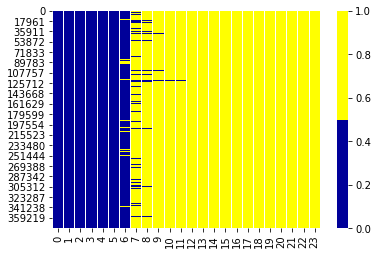

In [275]:
#Построим тепловую карту пропущенных значний
cols = data_homeFacts.columns[:]
colours = ['#000099', '#ffff00'] # желтый цвет - пропущенные значения
sns.heatmap(data_homeFacts[cols].isnull(), cmap=sns.color_palette(colours))

In [276]:
data_homeFacts.columns = data_homeFacts.columns.astype(str)

In [277]:
data['Year_built'] = data.homeFacts.apply(lambda x: x[0:4])
data['Remodeled_year'] = data_homeFacts['1']
data['Heating'] = data_homeFacts['2']
data['Cooling'] = data_homeFacts['3']
data['Parking'] = data_homeFacts['4']
data['lotsize_sqft'] = data_homeFacts['5']
data['Price/sqft'] = data_homeFacts['6']

In [278]:
data.Year_built = data.Year_built.apply(lambda x: x.replace(', na', '2019').replace(', ', '20').replace('None', '2019').replace('/,/s/d{2}', '2019').replace('No D', '2019'))

In [279]:
data.Year_built.value_counts().sample(5)

1941    1215
1952    2163
1981    3201
1980    3255
1812       1
Name: Year_built, dtype: int64

In [280]:
data.Year_built = data.Year_built.apply(lambda x: x.replace(',', '0').replace('120n', '2019').replace('5599', '2019'))
data.Year_built = data.Year_built.apply(lambda x: int(x))

In [281]:
data[data.Year_built < 1500].sample(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Pool,test2,sqft2,beds2,Year_built,Remodeled_year,Heating,Cooling,Parking,lotsize_sqft,Price/sqft
264054,active,0,single family,576 19th st,2,"1060, 1960, nan, nan, nan, 1,953 Sq. Ft., 793",yes,Brooklyn,"[{'rating': ['6', '8', '5', '6'], 'data': {'Di...",1892,11218,3,NY,NaN,0,0,1131116,"1,499,999",0,empty,1892,3,1060,1960,nan,nan,nan,"1,953 Sq. Ft.",793
172723,active,0,single family,5532 nw 57th pl,2,"1057, nan, Central Electric, Central Electric...",yes,Ocala,"[{'rating': ['1', '4', '3', '1', '6', '5', 'NR...",1042,34482,2,FL,1,0,0,562474,"$104,900",0,empty,1042,2,1057,nan,Central Electric,Central Electric,nan,8712,101
312874,active,0,georgian,ellisway rd #13,2,"1019, nan, nan, Heat Pump for A/C, Heat Pump...",yes,Charlotte,"[{'rating': [], 'data': {'Distance': [], 'Grad...",1811,28216,3,NC,NaN,0,0,3564047,"285,500",0,empty,1811,3,1019,nan,nan,Heat Pump for A/C,Heat Pump for Heat,nan,—


In [282]:
#удалим эти значения из датасета
data = data.loc[data['Year_built'] > 1500]

In [283]:
data['Remodeled_year'] = data['Remodeled_year'].apply(lambda x: x.replace('nan', '0').replace('None', '0'))#['Remodeled year'] if x['Remodeled year'] != 'None' else (x['Remodeled year'] if x['Remodeled year'] != 'nan' else x.Year_built, axis=1))

In [284]:
# заполним годом постройки если не было реконструкции здания
data['Remodeled_year'] = data['Remodeled_year'].astype(int)
data['Remodeled_year'] = data.apply(lambda x: x.Remodeled_year if x.Remodeled_year > x.Year_built else x.Year_built, axis=1)
data['Remodeled_year'] = data['Remodeled_year'].astype(int)

In [55]:
#Создадим новый признак
#data['years_old'] = data.Remodeled_year - data.Year_built

In [56]:
data.Remodeled_year.describe()

count    374650.000000
mean       1989.847847
std          31.523417
min        1700.000000
25%        1971.000000
50%        2001.000000
75%        2019.000000
max        2025.000000
Name: Remodeled_year, dtype: float64

In [285]:
#Обработаем признак обогрев
data['Heating'] = data['Heating'].apply(lambda x: x.lower())
data['Heating'] = data['Heating'].apply(lambda x: x.lstrip())
data['Heating'] = data['Heating'].apply(lambda x: x.replace('no data', 'forced').replace('natural ', '').replace(' heat', '').replace('none', 'forced').replace(' air', '').replace('(s)', '').replace('central gas', 'gas'))
data['Heating'] = data['Heating'].apply(lambda x: x.replace('/window unit', ''))

In [286]:
#Аналогично обработаем признак типа охлаждения
data['Cooling'] = data['Cooling'].apply(lambda x: x.lower())
data['Cooling'] = data['Cooling'].apply(lambda x: x.lstrip())
data['Cooling'] = data['Cooling'].apply(lambda x: x.replace('a/c (electric)', 'electric').replace('a/c', 'electric').replace('no data', 'central').replace('has nan', 'nan').replace('none', 'central').replace('(s)', ''))
data['Cooling'] = data['Cooling'].apply(lambda x: x.replace(' hot air/furnace', '').replace('/window unit', '').replace('gas forced air nan', 'nan').replace('central heat', 'central').replace('window unit', 'wall').replace('central nan', 'nan'))
data['Cooling'] = data['Cooling'].apply(lambda x: x.replace('natural gas', 'gas').replace('gas nan', 'nan').replace('forced air nan', 'nan').replace('electric nan', 'nan').replace('fans', 'fan').replace('electric hot air', 'electric').replace('air conditioning-', '').replace(' air conditioning', ''))
data['Cooling'] = data['Cooling'].apply(lambda x: x.replace('wall heat', 'wall').replace('stream nan', 'nan').replace('central pump nan', 'nan').replace(' - heat', ''))
data['Cooling'] = data['Cooling'].apply(lambda x: x.replace('walls', 'wall').replace(' 1 unit', '').replace(' unit', '').replace('central electric (gas)', 'central electric, central gas').replace('gas heat', 'gas').replace('gas (hot air)', 'gas'))

In [44]:
data['lotsize_sqft'].value_counts().head(5)

nan                22507
 nan               21029
None               20799
 —                 15987
Attached Garage     6177
Name: lotsize_sqft, dtype: int64

In [287]:
#площадь помещения имеется в признаке sqft - в этом слишком много пропущенных значений.Удалим
column_to_del.append('lotsize_sqft')

'Price/sqft' зависит от искомой величины - стоимость жилья - удаляем признака

In [288]:
column_to_del.append('Price/sqft')
# и удалим исходный признак
column_to_del.append('homeFacts')

#### stories

In [289]:
data.stories = data.stories.fillna('1.0')
data.stories = data.stories.apply(lambda x: x.lower())
data.stories = data.stories.apply(lambda x: x.replace('one', '1.0').replace('two', '2.0').replace('.00', '.0').replace(' story', '').replace(' or more', '').replace(' stories', ''))
data.stories = data.stories.apply(lambda x: x.replace('+', '').replace('three', '3').replace('lot', '3').replace('townhouse', '3'))
data.stories = data.stories.apply(lambda x: x.replace(' level', '').replace('ranch/1', '1').replace('/basement', '').replace(', site built', '').replace('condominium', '3').replace('multi/split', '3').replace('.000', ''))
data.stories = data.stories.apply(lambda x: x.replace('acreage', '3').replace('stories/levels', '1').replace('ranch', '1').replace('traditional', '1').replace(' basement', ''))
data.stories = data.stories.apply(lambda x: x if x.isnumeric() == True else x[0])


In [290]:
data.stories = data.stories.astype(str).apply(lambda x: x if x.isnumeric() == True else '1')
data.stories = data.stories.astype(int)
#скорее всего нулевой этаж - это первый - основание - где расположена плоадь. Если понимается этажность продаваемого помещения
#data.stories = data.stories.astype(str).apply(lambda x: x.replace('0', '1'))

Обработаем признак schools: создадим отдельный датафреймм - где разделим оценки, расстояние до , название школы и классы. Оценки и расстояния обработаем в дополнительных датафреймах. Нужные признаки запишет в исходный data

#### schools

In [291]:
data['schools'] = data['schools'].astype(str).apply(lambda x: None if x.strip() == '' else x)
data.schools = data.schools.astype(str).apply(lambda x: x.replace("'", '').replace('[', '').replace(']', '').replace('{', '').replace('}', ''))
data.schools = data.schools.apply(lambda x: x.replace('rating: ', '').replace('/10', '').replace(', data: Distance:', ';').replace('mi,', ',').replace(', Grades:', ';').replace(', name:', ';'))
#пропущенные значения заполним средней оценкой 3 и средним расстоянием 6
data.schools = data.schools.apply(lambda x: x.replace('; ; ; ', '0, 0, 0; 0, 0, 0; 0-0; No'))

#расстояния 0.0 до школы - возможно стоит заменить на 0.1
data.schools = data.schools.apply(lambda x: x.replace('0.0', '0.1'))

In [292]:
data_schools = data['schools'].str.split(';', expand=True)
data_schools.columns = ['school_rating', 'school_distance', 'school_grades', 'school_name']
data_schools.head(6)

,school_rating,school_distance,school_grades,school_name
0,"4, 4, 7, NR, 4, 7, NR, NR","2.7 , 3.6 , 5.1 , 4.0 , 10.5 , 12.6 , 2.7 , 3.1","3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12","Southern Pines Elementary School, Southern Mi..."
1,"4, None, 4","1.65, 1.32, 1.01","9-12, 3-8, PK-8","East Valley High School&Extension, Eastvalley..."
2,"8, 4, 8","1.19, 2.06, 2.63","6-8, K-5, 9-12","Paul Revere Middle School, Brentwood Science ..."
3,"9, 9, 10, 9","1.05, 0.1, 1.05, 0.81","5-6, PK-4, 7-8, 9-12","Mcculloch Intermediate School, Bradfield Elem..."
4,"4, 5, 5","5.96, 3.25, 3.03","7-8, 9-12, PK-6","Southwest Middle School, Bayside High School,..."
5,"0, 0, 0","0, 0, 0",0-0,No


In [66]:
data_schools.sample(4)

,school_rating,school_distance,school_grades,school_name
62279,"4, 9, 7","0.14, 3.06, 4.6","K-6, 9-12, 6-8","Cason Lane Academy, Blackman High School, Roc..."
262587,"9, 8, 5","0.13, 0.4, 1.82","6-8, K-5, 9-12","Alfred B. Nobel Charter Middle School, Topeka..."
298433,"5, 8","0.5 , 0.2","PK-8, 8-12","Dr. Rolando Espinosa K-8 Center, Ronald W. Re..."
359213,"10, NR, 10, 9, 8, 2","0.1 , 0.2 , 0.7 , 2.4 , 2.4 , 1.7","K to 5, K to 12, 6 to 8, 6 to 8, 6 to 11, 6 t...","East Side Elementary School, PS 267, The Brow..."


In [293]:
data_schools.school_rating = data_schools.school_rating.apply(lambda x: x.replace('NR', '3').replace('None','3').replace('NA', '3'))

In [294]:
def find_num(count_school):

    count = Counter(count_school) 
    return count[',']

In [295]:
# количество школ
data['count_school'] = data_schools['school_rating'].apply(find_num) + 1

In [296]:
# общий рейтинг школ
data['school_raiting'] = data_schools['school_rating'].apply(lambda x: x.replace(', ', ' + '))
data['school_raiting'] = data_schools['school_rating'].apply(lambda x: sum(float(y) for y in x.split(', ')))
# средний рейтинг школ
data['average_raiting_school'] = data['school_raiting'] / data.count_school

Так как новый признак является функцией старых двух - то оставим количество школ и средний рейтинг

In [297]:
data_schools_35 = data_schools['school_rating'].str.split(', ', expand=True)
data_schools_35.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,4,4,7,3,4,7,3,3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,4,3,4,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,8,4,8,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,9,9,10,9,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,4,5,5,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [298]:
data_schools_35_max = data_schools_35.fillna(0)
data_schools_35_max = data_schools_35_max.astype(int)

In [73]:
data_schools_35_max

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,4,4,7,3,4,7,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8,4,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,9,10,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,10,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
377181,1,5,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
377182,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
377183,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [299]:

data['max_rating'] = data_schools_35_max.max(axis=1)

In [300]:
data_schools_35_min = data_schools_35.fillna(11)
data_schools_35_min = data_schools_35_min.astype(int)


In [301]:
data['min_rating'] = data_schools_35_min.min(axis=1)

In [302]:
# Обработаем расстояние до школ
data['school_distance'] = data_schools['school_distance'].apply(lambda x: x.replace(', ', ' + '))
data['school_distance'] = data_schools['school_distance'].apply(lambda x: sum(float(y) for y in x.split(', ')))
# среднее расстояние до школ
data['average_distance_school'] = data['school_distance'] / data.count_school

In [303]:
data_schools_35 = data_schools['school_distance'].str.split(', ', expand=True)
data_schools_35.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,2.7,3.6,5.1,4.0,10.5,12.6,2.7,3.1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,1.65,1.32,1.01,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,1.19,2.06,2.63,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,1.05,0.1,1.05,0.81,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,5.96,3.25,3.03,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [304]:
data_schools_35_max = data_schools_35.fillna(0)
data_schools_35_max = data_schools_35_max.astype(float)
data['max_distance'] = data_schools_35_max.max(axis=1)

In [305]:
data_schools_35_min = data_schools_35.fillna(1600)
data_schools_35_min = data_schools_35_min.astype(float)
data['min_distance'] = data_schools_35_min.min(axis=1)

In [306]:
# Посмотрим на школы где расстояние до школы есть 0
data[data.min_distance == 0].sample(5)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Pool,test2,sqft2,beds2,Year_built,Remodeled_year,Heating,Cooling,Parking,lotsize_sqft,Price/sqft,count_school,school_raiting,average_raiting_school,max_rating,min_rating,school_distance,average_distance_school,max_distance,min_distance
267472,active,0,single family,7519 finnigan rd,2,"2019, nan, nan, Multi-Zone A/C, Multi-Zone H...",yes,Charlotte,"0, 0, 0; 0, 0, 0; 0-0; No",1518,28215,3,NC,1,0,0,3576304,"222,990",0,empty,1518,3,2019,2019,nan,multi-zone electric,Multi-Zone Heat,nan,—,3,0.0,0.0,0,0,0.0,0.00,0.0,0.0
28494,for sale,0,townhouse,1104 w somerville ave,2,"1925, nan, Gas, None, Attached Garage, 1,360,...",yes,Philadelphia,"0, 0, 0; 0, 0, 0; 0-0; No",1350,19141,4,PA,2,0,0,PAPH844524,"$154,900",0,empty,1350,4,1925,1925,gas,central,Attached Garage,"1,360",115,3,0.0,0.0,0,0,0.0,0.00,0.0,0.0
182894,active,0,mid rise,1878 adam clayton powell jr blvd #26,2,"1925, nan, nan, nan, nan, —, 397",yes,New York,"4, 9, 3, 2; 0.1 , 0.1 , 0.0 , 0.0 ; K to 5, K ...",980,10026,3,NY,1,0,0,4848267,"389,000",0,empty,980,3,1925,1925,nan,nan,nan,—,397,4,18.0,4.5,9,2,0.2,0.05,0.1,0.0
359605,active,0,straight thru,2929 gerritt st,2,"1920, nan, nan, nan, nan, 630 Sq. Ft., 219",yes,Philadelphia,"NR, 3, NR, 3; 0.0 , 0.2 , 0.3 , 0.7 ; Preschoo...",1140,19146,3,PA,1,0,0,PAPH843914,"249,900",0,empty,1140,3,1920,1920,nan,nan,nan,630 Sq. Ft.,219,4,12.0,3.0,3,3,1.2,0.30,0.7,0.0
341882,active,0,single family,unknown address,2,"1989, nan, nan, nan, nan, —, 247",yes,Miami,"0, 0, 0; 0, 0, 0; 0-0; No",1152,33156,3,FL,1,0,0,H10751588,"285,000",0,empty,1152,3,1989,1989,nan,nan,nan,—,247,3,0.0,0.0,0,0,0.0,0.00,0.0,0.0


In [82]:
data.schools.iloc[31]

'5, 2, 4; 0 , 3 , 2.9 ; PK-5, 6-8, 9-12; Egypt Lake Elementary School, Memorial Middle School, Hillsborough High School'

In [307]:
data_schools_name35 = data_schools['school_name'].str.split(', ', expand=True)
data_schools_name35.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,Southern Pines Elementary School,Southern Middle School,Pinecrest High School,Southern Pines Primary School,"""Crains Creek Middle School""",Union Pines High School,Episcopal Day Private School,Calvary Christian Private School,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,East Valley High School&Extension,Eastvalley Middle School,Trentwood Elementary School,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,Paul Revere Middle School,Brentwood Science School,Palisades Charter High School,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,Mcculloch Intermediate School,Bradfield Elementary School,Highland Park Middle School,Highland Park High School,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,Southwest Middle School,Bayside High School,Westside Elementary School,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,No,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [84]:
data_schools_name35[0].value_counts().head(20)

 Air Base Elementary School                  11309
 No                                           4256
 Hope College Prep High School                2931
 Communication And Media Arts High School     2686
 Harns Marsh Elementary School                2203
 Nyc Lab Ms For Collaborative Studies         1887
 Myakka River Elementary School               1515
 East Elementary School                       1379
 Liberty Elementary School                    1370
 Jose De Diego Middle School                  1318
 Vineland Elementary School                   1209
 Harbordale Elementary School                 1120
 Hector A. Cafferata Jr Elementary School     1088
 Bayview Elementary School                    1007
 Shenandoah Middle School                      986
 Old Kings Elementary School                   947
 Laurel Elementary School                      925
 Glenville High School                         892
 Sunrise Elementary School                     852
 Aventura Waterways K-8 Center 

Обозначим отсутствие школ. Создадим признаки школ: Elementary, Middle, High, Private. И дополнительно 'Air Base', 'Hope', 'Media Arts', 'East', 'Liberty', 'Harns', 'Nyc Lab' и 'Myakka'

In [308]:
#Обозначим отсутствие школ
data['No_school'] = data_schools_name35[0].apply(lambda x: len(x))
data['No_school'] = data.No_school.apply(lambda x: 1 if x == 3 else 0)

In [309]:
data['Elementary'] = data.schools.apply(lambda x: 1 if 'Elementary' in x else 0)
data['Middle'] = data.schools.apply(lambda x: 1 if 'Middle' in x else 0)
data['High'] = data.schools.apply(lambda x: 1 if 'High' in x else 0)
data['Private'] = data.schools.apply(lambda x: 1 if 'Private' in x else 0)

In [310]:
data['Air Base'] = data.schools.apply(lambda x: 1 if 'Air Base' in x else 0)
data['Hope'] = data.schools.apply(lambda x: 1 if 'Hope' in x else 0)
data['Media Arts'] = data.schools.apply(lambda x: 1 if 'Media Arts' in x else 0)
data['East'] = data.schools.apply(lambda x: 1 if 'East' in x else 0)
data['Liberty'] = data.schools.apply(lambda x: 1 if 'Liberty' in x else 0)
data['Harns'] = data.schools.apply(lambda x: 1 if 'Harns' in x else 0)
data['Nyc Lab'] = data.schools.apply(lambda x: 1 if 'Nyc Lab' in x else 0)
data['Myakka'] = data.schools.apply(lambda x: 1 if 'Myakka' in x else 0)

In [311]:
#из признака schools все взяли - можно удалить
column_to_del.append('school_distance')
column_to_del.append('school_raiting')
column_to_del.append('schools')

#### Parking& Heating & Cooling

In [312]:
data.Parking = data.Parking.fillna('None')
data['Parking'] = data['Parking'].apply(lambda x: x.lower())
data['Parking'] = data['Parking'].apply(lambda x: x.lstrip())

In [313]:
data.Parking = data.Parking.apply(lambda x: x.replace('none', 'no').replace('has nan', 'no').replace('nan', 'no').replace(' data', '').replace('1 space', '1').replace(' - side', ''))

In [314]:
data['no_parking'] = data.Parking.apply(lambda x: 0 if x == 'no' else(0 if x == '—' else 1))
data['attached garage'] = data.Parking.apply(lambda x: 1 if x == 'attached garage' else 0)

In [315]:
data['detached garage'] = data.Parking.apply(lambda x: 1 if x == 'detached garage' else 0)
data['3_garage'] = data.Parking.apply(lambda x: 1 if x == '3' else (1 if x == '4' else 0))
data['5_garage'] = data.Parking.apply(lambda x: 1 if x == '5' else (1 if x == '6' else 0))

In [316]:
column_to_del.append('Parking')
column_to_del.append('Cooling')
column_to_del.append('Heating')
column_to_del.append('Remodeled_year')

In [94]:
column_to_del

['private pool',
 'PrivatePool',
 'test2',
 'sqft2',
 'beds2',
 'MlsId',
 'lotsize_sqft',
 'Price/sqft',
 'homeFacts',
 'school_distance',
 'school_raiting',
 'schools',
 'Parking',
 'Cooling',
 'Heating',
 'Remodeled_year']

In [317]:
# удалим ненужные признаки
data = data.drop(column_to_del, axis=1)

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374650 entries, 0 to 377184
Data columns (total 40 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   status                   374650 non-null  object 
 1   propertyType             374650 non-null  object 
 2   street                   374650 non-null  object 
 3   baths                    374650 non-null  int32  
 4   fireplace                374650 non-null  object 
 5   city                     374616 non-null  object 
 6   sqft                     374650 non-null  int64  
 7   zipcode                  374650 non-null  object 
 8   beds                     374650 non-null  int64  
 9   state                    374650 non-null  object 
 10  stories                  374650 non-null  int32  
 11  mls-id                   374650 non-null  int64  
 12  target                   374650 non-null  object 
 13  Pool                     374650 non-null  int32  
 14  Year

In [97]:
data.sample(5).T

,130538,346671,327169,261761,21766
status,for sale,active,active,active,for sale
propertyType,coop,1 story,single family,single family,single family
street,2400 ne 9th st apt 101,16020 sw 109th st,1107 ridgeview dr,20801 mykonos ct,2633 3rd ave
baths,2,2,2,2,2
fireplace,yes,yes,2,yes,yes
city,Fort Lauderdale,Miami,Nashville,North Fort Myers,Sacramento
sqft,650,1200,5216,1968,1150
zipcode,33304,33196,37220,33917,95818
beds,2,3,3,2,2
state,FL,FL,TN,FL,CA


## Полученные данные можно разбить на:

In [318]:
#
numerical_columns = ['baths', 'sqft', 'beds', 'stories', 'mls-id', 'target', 'count_school', 'average_raiting_school', 'max_rating', 'min_rating',
       'average_distance_school', 'max_distance',  'min_distance']
binary_columns = ['Pool', 'No_school', 'Elementary', 'Middle', 'High', 'Private',
       'Air Base', 'Hope', 'Media Arts', 'East', 'Liberty', 'Harns', 'Nyc Lab',
       'Myakka', 'no_parking', 'attached garage', 'detached garage', '3_garage', '5_garage']
categorial_columns = ['status', 'propertyType', 'street', 'fireplace', 'city', 'zipcode', 'state', 'homeFacts', 'schools']

data_columns = ['Year_built', 'Remodeled_year']


### Предоработка

In [99]:
#данные стоимости жилья с $/mo относятся к аренде жилья
data[data.target.apply(lambda x: 'mo' in x)].sample(3)

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,mls-id,target,Pool,Year_built,count_school,average_raiting_school,max_rating,min_rating,average_distance_school,max_distance,min_distance,No_school,Elementary,Middle,High,Private,Air Base,Hope,Media Arts,East,Liberty,Harns,Nyc Lab,Myakka,no_parking,attached garage,detached garage,3_garage,5_garage
236060,for rent,single family,3507 cripple creek dr,2,yes,Dallas,2369,75224,4,TX,1,0,"$2,300/mo",0,1964,3,3.0,4,2,1.563333,1.92,0.85,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
167080,for rent,townhouse,4712 abbott ave #208,2,yes,Highland Park,526,75205,3,TX,1,0,"$1,400/mo",0,1958,4,9.5,10,9,1.105000,1.75,0.61,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28395,for rent,single family,1737 laurel st,2,yes,Indianapolis,1872,46203,2,IN,1,0,$950/mo,0,1900,2,2.0,3,1,1.600000,2.16,1.04,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [319]:
#Приведем к числовому формату
data.target = data.target.astype(str).apply(lambda x: x.replace('$', '').replace('+', '').replace(',', '').replace('/mo', ''))
data.target = data.target.str.replace(' - \d{2,5}', '')
data = data.loc[data['target'] != 'nan']
data.target = data.target.apply(lambda x: int(x))

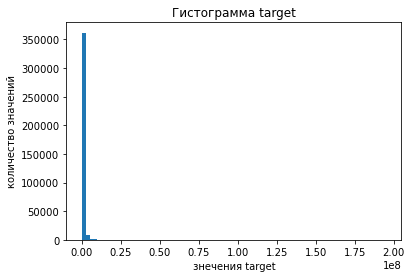

In [101]:
# посмотрим на распределение целевой переменной
gistogramma('target')

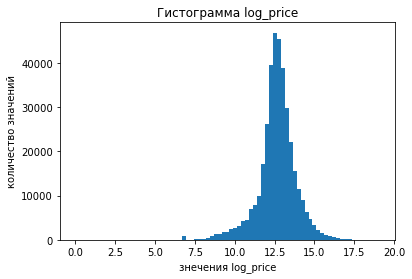

In [320]:
# возьмем логарифм и еще раз построим распределение
data['log_price'] = np.log(data.target)
gistogramma('log_price')

In [103]:
# Посмотрим на наличие выбросов
outliers('log_price')

выбросы ниже 10.488810418471006


In [104]:
#удалим данные, где логарифм цены меньше 6. сомнительная стоимость домов
data.target[data.log_price < 6].value_counts()

1      15
3       2
30      1
29      1
250     1
25      1
20      1
400     1
393     1
8       1
Name: target, dtype: int64

In [321]:
data.drop(data.loc[np.log(data.target) < 6].index, inplace=True)

В модель введем логарифм цены. А после предсказания вернем обратно.

####  Посмотрим как признаки влияют на стоимость жилья

In [106]:
data.describe()

,baths,sqft,beds,stories,mls-id,target,Pool,Year_built,count_school,average_raiting_school,max_rating,min_rating,average_distance_school,max_distance,min_distance,No_school,Elementary,Middle,High,Private,Air Base,Hope,Media Arts,East,Liberty,Harns,Nyc Lab,Myakka,no_parking,attached garage,detached garage,3_garage,5_garage,log_price
count,374625.000000,3.746250e+05,374625.000000,374625.000000,3.746250e+05,3.746250e+05,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000,374625.000000
mean,2.383984,7.093232e+03,3.296427,1.470673,3.584342e+06,6.447577e+05,0.118174,1986.034821,4.347299,4.925883,6.665514,3.387956,2.829472,4.994270,1.166816,0.011353,0.826533,0.745933,0.925886,0.121158,0.069539,0.020108,0.007170,0.044031,0.017634,0.005881,0.013413,0.006521,0.558011,0.191327,0.037320,0.021510,0.004290,12.641245
std,1.125335,1.501566e+06,1.539111,1.602546,9.243342e+08,1.841431e+06,0.322815,34.040645,4.593886,1.898552,2.389997,1.920796,5.874023,7.904447,5.336515,0.105943,0.378651,0.435336,0.261957,0.326312,0.254369,0.140370,0.084371,0.205164,0.131616,0.076459,0.115037,0.080490,0.496624,0.393347,0.189545,0.145076,0.065355,1.203192
min,0.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,5.000000e+02,0.000000,1700.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.214608
25%,2.000000,1.200000e+03,3.000000,1.000000,0.000000e+00,1.870000e+05,0.000000,1963.000000,3.000000,3.500000,5.000000,2.000000,1.033333,1.600000,0.340000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.138864
50%,2.000000,1.677000e+03,3.000000,1.000000,0.000000e+00,3.200000e+05,0.000000,1998.000000,3.000000,4.875000,7.000000,3.000000,1.763333,2.800000,0.670000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.676076
75%,2.000000,2.496000e+03,4.000000,2.000000,0.000000e+00,5.822760e+05,0.000000,2019.000000,5.000000,6.333333,9.000000,4.000000,3.253333,5.400000,1.300000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.274700
max,44.000000,7.959794e+08,144.000000,95.000000,5.655481e+11,1.950000e+08,1.000000,2025.000000,65.000000,10.000000,10.000000,10.000000,1590.830000,1591.090000,1590.380000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.088510


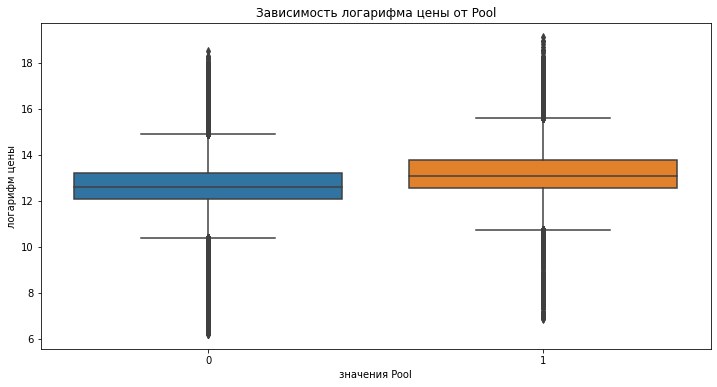

In [107]:
#Наличие бассейна
graf_cat('Pool')

Среднее значение стоимости цены на жилье выше при наличии бассейна.

In [108]:
#уникальных городов
data.city.nunique()

2019

In [109]:
#Посмотрим на количество объявления по городам в %
data.city.value_counts().head(25)*100/len(data)

Houston            6.514781
San Antonio        4.137738
Miami              4.112913
Jacksonville       2.640507
Dallas             2.341008
Brooklyn           1.933400
New York           1.842643
Chicago            1.839973
Charlotte          1.741475
Las Vegas          1.594928
Fort Worth         1.462262
Orlando            1.380047
Austin             1.370170
Fort Lauderdale    1.356290
Cleveland          1.336270
Nashville          1.330931
Philadelphia       1.272739
Tampa              1.256190
Washington         1.223624
Los Angeles        1.111512
Seattle            1.082683
Atlanta            1.054388
Ocala              0.886486
Palm Coast         0.866200
Kissimmee          0.831231
Name: city, dtype: float64

Ограничимся 1% данных и оставим 22 значения

In [322]:
# Ограничим категориалный признак город. Городов много - обрезав на 22 значений можно многие зависимости потерять. Попробуем взять 50 городов
data['city2'] = data.city
cities = data.city2.value_counts()[:22]
# Выделим 5 основных, остальные заменим общим типом "другой"
data['city2'] = data['city2'].apply(lambda x: x if x in cities else 'другой')

In [111]:
#сгруппируем и посмотрим как меняется стоимость жилья от города
data.groupby('city2')['target'].describe().head(10)

,count,mean,std,min,25%,50%,75%,max
city2,,,,,,,,
Atlanta,3950.0,5.579015e+05,8.678684e+05,1000.0,202391.00,329900.0,589444.25,21000000.0
Austin,5133.0,7.478649e+05,1.150618e+06,1150.0,319000.00,461705.0,699000.00,35000000.0
Brooklyn,7243.0,1.324590e+06,1.260773e+06,2000.0,630000.00,959000.0,1590000.00,18000000.0
Charlotte,6524.0,4.665604e+05,5.217778e+05,1095.0,230000.00,324000.0,485000.00,9600000.0
Chicago,6893.0,5.091714e+05,9.762419e+05,1080.0,159000.00,290000.0,529900.00,45000000.0
Cleveland,5006.0,1.795440e+05,3.267373e+05,950.0,45000.00,94900.0,217887.00,7148890.0
Dallas,8770.0,6.914751e+05,1.185993e+06,1000.0,215103.75,399000.0,660000.00,21950000.0
Fort Lauderdale,5081.0,1.161074e+06,2.138555e+06,1000.0,299900.00,529900.0,1080000.00,32000000.0
Fort Worth,5478.0,3.351365e+05,3.627060e+05,1200.0,199900.00,267779.5,359000.00,6975000.0


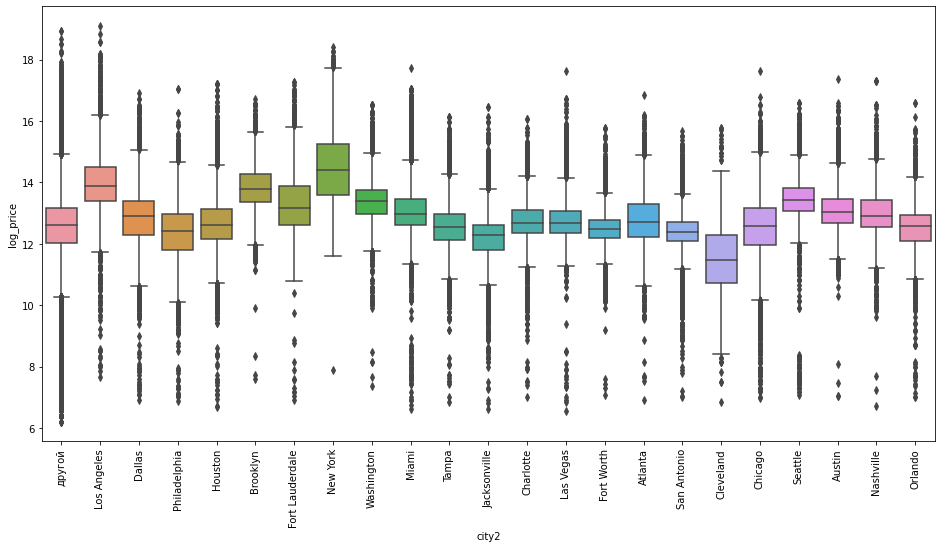

In [112]:
# Визуализируем
var = 'city2'
data_m = pd.concat([data['log_price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="log_price", data=data_m)
fig.axis();
plt.xticks(rotation=90);

In [113]:
#Обработаем категориальный признак улицы: сколько уникальный значений
data.street.nunique()

333913

In [114]:
data.street.value_counts()

unknown address             1827
2103 e state hwy 21           57
11305 gulf fwy                54
17030 youngblood rd.          38
ne 58th cir                   34
                            ... 
1603 hickory ave               1
22264 n 182nd ln               1
112 birdie ct                  1
14725 ne 4th pl                1
4606 commander dr #1124        1
Name: street, Length: 333913, dtype: int64

названия улиц даны с адресом, поэтому они не повторяются. Можно попробовать выделить тип улиц отдельно.

In [323]:
#Введем новые бинарные признаки из наиболее частых: 'drive', 'road', 'lane', 'trail', 'ave'
data['drive'] = data.street.apply(lambda x: 1 if 'drive' in x else (1 if ' dr' in x else 0))
data['road'] = data.street.apply(lambda x: 1 if 'road' in x else (1 if ' rd' in x else 0))
data['lane'] = data.street.apply(lambda x: 1 if 'lane' in x else (1 if ' ln' in x else 0))
data['trail'] = data.street.apply(lambda x: 1 if 'trail' in x else (1 if ' trl' in x else 0))

In [324]:
data['hwy'] = data.street.apply(lambda x: 1 if 'hwy' in x else 0)
data['ave'] = data.street.apply(lambda x: 1 if 'avenue' in x else (1 if ' ave' in x else 0))
data['street'] = data.street.apply(lambda x: 1 if 'street' in x else (1 if ' st' in x else 0))

In [325]:
cols = ['drive', 'road', 'lane', 'trail', 'hwy', 'ave', 'street']

In [118]:
for i in cols:
        print(i, data[i].value_counts()*100/len(data))

drive 0    82.547614
1    17.452386
Name: drive, dtype: float64
road 0    90.744077
1     9.255923
Name: road, dtype: float64
lane 0    93.641642
1     6.358358
Name: lane, dtype: float64
trail 0    98.898365
1     1.101635
Name: trail, dtype: float64
hwy 0    99.730931
1     0.269069
Name: hwy, dtype: float64
ave 0    83.11645
1    16.88355
Name: ave, dtype: float64
street 0    76.470337
1    23.529663
Name: street, dtype: float64


hwy содержится только в 0.27 % данных. И значения 1 для признака lane только в 1.1 %. Можно удалиь эти признаки 

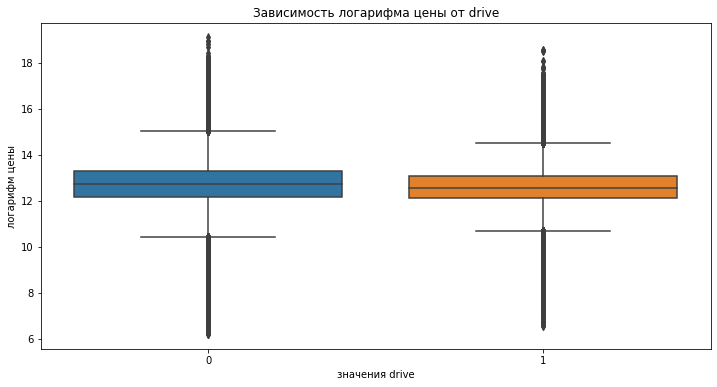

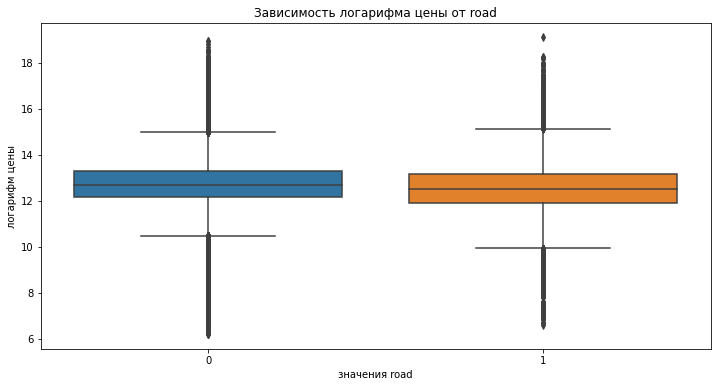

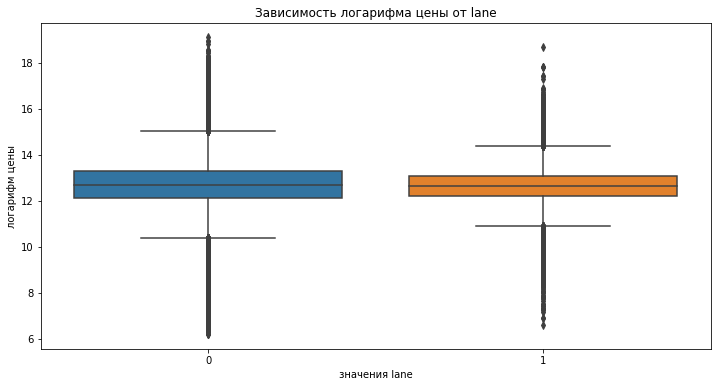

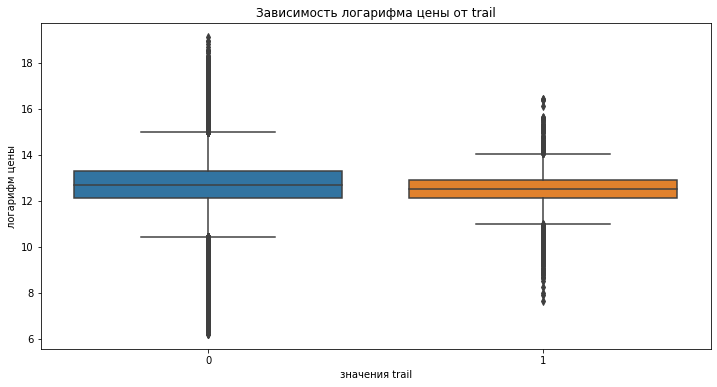

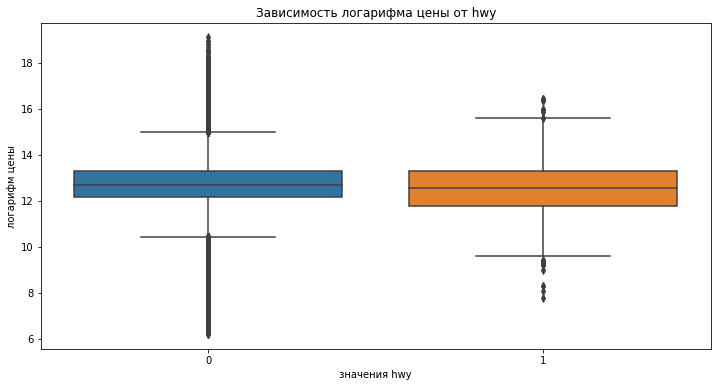

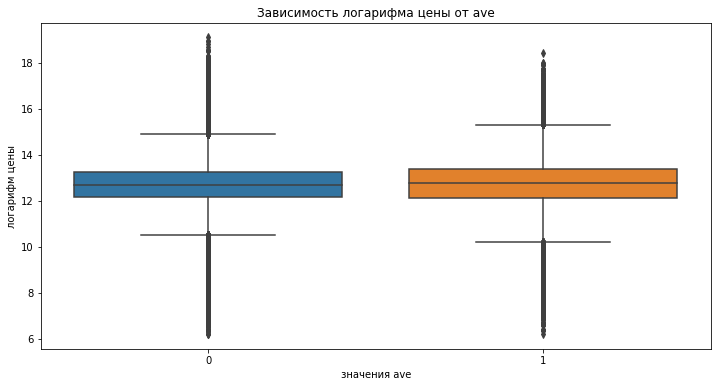

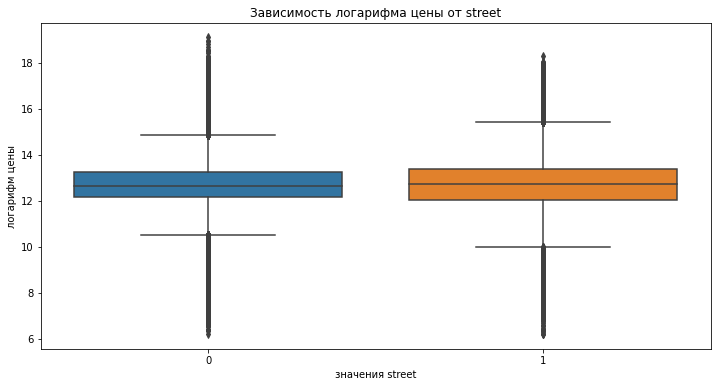

In [119]:
for i in cols:
    graf_cat(i)

drive, ave, street можно удалить сразу: разницы нет

In [120]:
# сколько уникальных значений типа жилья
data['propertyType'].nunique()

1026

In [121]:
data['propertyType'].value_counts().head(30)*100/len(data)

single family          58.644511
condo                  11.432766
land                    8.389990
townhouse               4.898498
multi family            3.247514
condo/coop              2.055656
traditional             1.578111
coop                    1.023690
1 story                 0.981782
mobile/manufactured     0.923590
contemporary            0.740207
2 stories               0.649183
single detached         0.622489
ranch                   0.519186
high rise               0.489823
colonial                0.331532
apartment               0.212746
other                   0.166033
transitional            0.149483
florida                 0.148415
bungalow                0.120921
spanish                 0.099299
farms/ranches           0.099032
garden                  0.081682
cape cod                0.075542
craftsman               0.057391
single contemporary     0.057124
condo, contemporary     0.053921
split level             0.053387
mediterranean           0.045379
Name: prop

Ограничимся 1% и оставим 8 значений

In [326]:
# Выделим 8 основных, остальные заменим общим типом "other"
data['propertyType2'] = data.propertyType
propertyType = data.propertyType2.value_counts()[:8]
data['propertyType2'] = data['propertyType2'].apply(lambda x: x if x in propertyType else 'other')

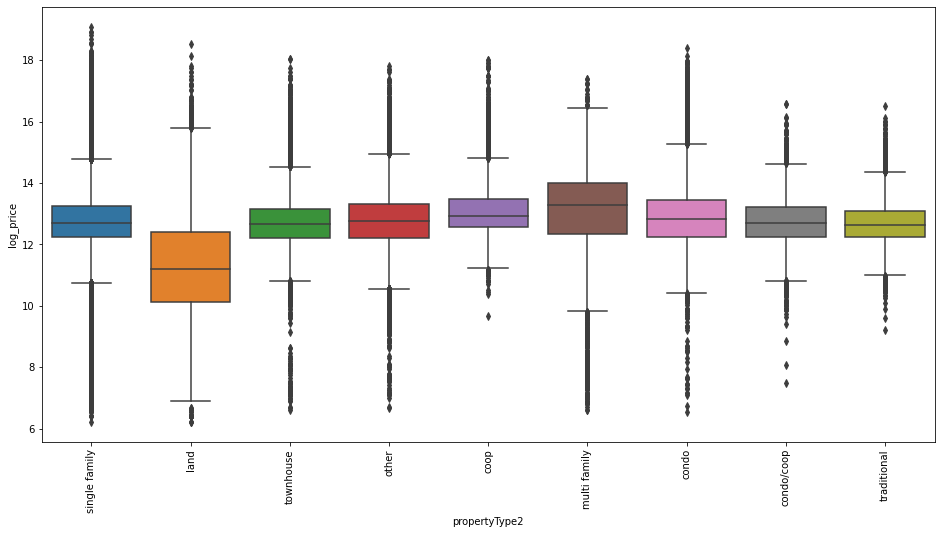

In [123]:
# Визуализируем
var = 'propertyType2'
data_m = pd.concat([data['log_price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="log_price", data=data_m)
fig.axis();
plt.xticks(rotation=90);

In [124]:
# Рассмотрим этажность продаваемого жилья
data.stories.describe()

count    374625.000000
mean          1.470673
std           1.602546
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          95.000000
Name: stories, dtype: float64

In [125]:
# Посмотрим на наличие выбросов
outliers('stories')

выбросы выше 3.5


<AxesSubplot:xlabel='stories'>

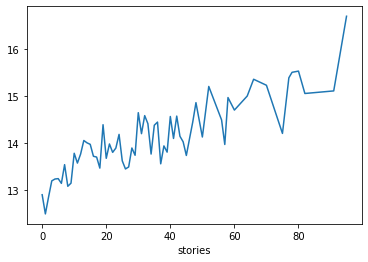

In [126]:
data.groupby('stories')['log_price'].mean().plot()

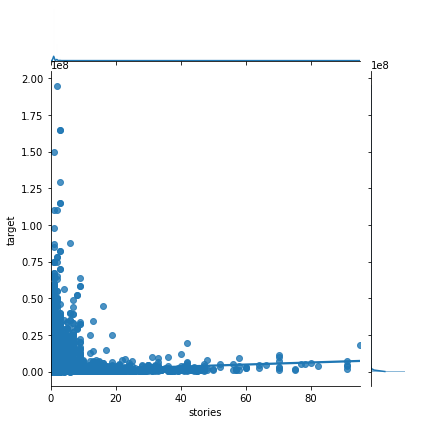

In [127]:
sns.jointplot(x=data['stories'], y=data['target'], kind='reg')

In [128]:
data[data.target > 75000000]

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,mls-id,target,Pool,Year_built,count_school,average_raiting_school,max_rating,min_rating,average_distance_school,max_distance,min_distance,No_school,Elementary,Middle,High,Private,Air Base,Hope,Media Arts,East,Liberty,Harns,Nyc Lab,Myakka,no_parking,attached garage,detached garage,3_garage,5_garage,log_price,city2,drive,road,lane,trail,hwy,ave,propertyType2
54164,for sale,single family,0,24,yes,Beverly Hills,38000,90210,12,CA,2,0,110000000,1,2000,3,7.333333,10,5,4.363333,5.26,3.33,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,18.515991,другой,1,0,0,0,0,0,single family
110083,for sale,single family,0,2,yes,Los Angeles,1200,90077,3,CA,1,0,150000000,1,2019,3,7.333333,10,5,2.183333,2.94,1.28,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18.826146,Los Angeles,0,0,0,0,0,0,single family
119862,for sale,single family,0,2,yes,Los Angeles,12201,90077,9,CA,3,0,115000000,1,1936,3,7.333333,10,5,1.800000,3.00,0.70,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18.560443,Los Angeles,1,0,0,0,0,0,single family
132425,for sale,single family,0,2,yes,Los Angeles,1200,90077,11,CA,2,0,195000000,1,1935,2,8.500000,10,7,2.150000,3.00,1.30,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,19.088510,Los Angeles,0,1,0,0,0,0,single family
143528,for sale,single family,0,23,yes,Beverly Hills,28660,90210,20,CA,3,0,165000000,1,1998,3,7.333333,10,5,4.813333,5.84,3.72,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,18.921456,другой,0,0,0,0,0,0,single family
151594,for sale,condo,0,14,yes,New York,19815,10016,11,NY,1,0,98000000,1,2016,3,6.000000,8,3,1.633333,3.30,0.40,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,18.400478,New York,0,0,0,0,0,1,condo
178931,for sale,single family,0,2,yes,Beverly Hills,43000,90210,12,CA,3,0,129000000,1,2002,3,7.333333,10,5,3.500000,5.20,1.50,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,18.675323,другой,0,0,1,0,0,0,single family
257052,for sale,single family,0,22,yes,Los Angeles,30000,90077,17,CA,2,0,78000000,1,1939,3,7.333333,10,5,1.890000,2.98,0.76,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,18.172219,Los Angeles,0,0,0,0,0,0,single family
273381,for sale,single family,0,2,yes,Beverly Hills,18543,90210,6,CA,3,0,82500000,1,2016,2,9.000000,10,8,2.050000,2.50,1.60,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,18.228309,другой,0,1,0,0,0,0,single family
279166,active,single family,0,2,yes,New York,1200,10036,3,NY,1,0,85000000,0,2019,5,7.000000,9,2,1.560000,3.20,0.20,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,18.258162,New York,0,0,0,0,0,0,single family


In [327]:
#Удалим верхние выбросы при этажности менее 5
data = data.drop(data[data['target']>75000000].index).reset_index(drop=True)

In [130]:
#Попробуем добавить логарифм
#data['stories_log'] = np.log(data.stories + 1)

Чем выше этажность, тем выше цена. попробуем ограничить этажность 50 этажами

In [131]:
outliers('beds')

выбросы ниже 1.5


In [132]:
outliers('baths')

выбросы ниже 2.0


In [133]:
data.beds.describe()

count    374608.000000
mean          3.296128
std           1.538026
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max         144.000000
Name: beds, dtype: float64

In [134]:
data.baths.describe()

count    374608.000000
mean          2.383724
std           1.123342
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          44.000000
Name: baths, dtype: float64

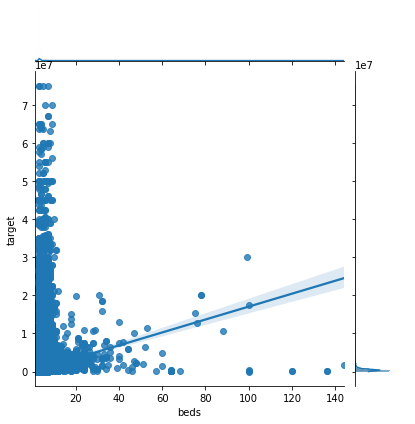

In [135]:
sns.jointplot(x=data['beds'], y=data['target'], kind='reg')

In [328]:
#Удалим выбросы - где спален больше 75, а стоимость меньше 10^7
data = data.drop(data[(data['beds']>50) 
                         & (data['target']<10000000)].index).reset_index(drop=True)

<AxesSubplot:xlabel='beds'>

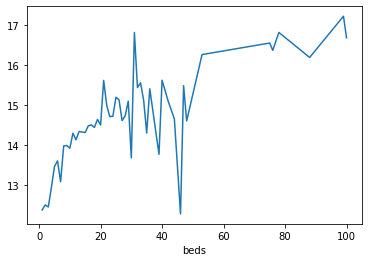

In [137]:
data.groupby('beds')['log_price'].mean().plot()

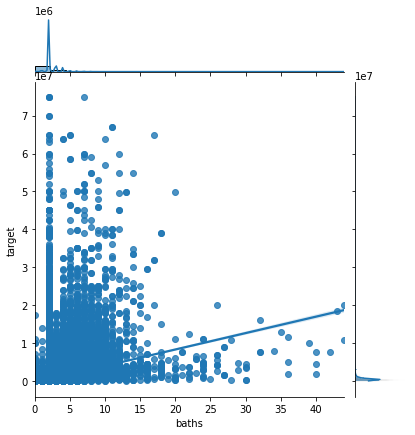

In [138]:
sns.jointplot(x=data['baths'], y=data['target'], kind='reg')

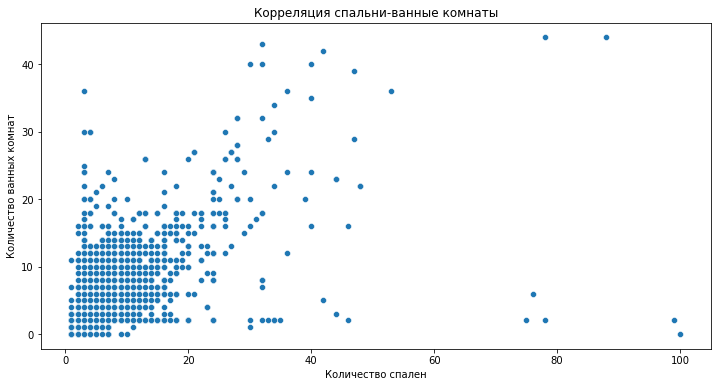

In [139]:
# look at the beds & baths outlier correlation
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='beds', y='baths')
plt.xlabel(
    'Количество спален')
plt.ylabel(
    'Количество ванных комнат')
plt.title('Корреляция спальни-ванные комнаты', fontsize=12)
plt.show()

Чем больше ванных, тем дороже жилье. Можно попробовать ограничить количество.  Или взять логарифм

In [140]:
#Рассмотрим признак статус
data.status.nunique()

85

In [141]:
data.status.value_counts().head(15)*100/len(data)

for sale                      63.731144
active                        28.409024
foreclosure                    1.683620
new construction               1.457215
pending                        1.388600
pre-foreclosure                0.931251
contract                       0.796956
auction                        0.694433
contingent                     0.247497
new                            0.184221
price change                   0.150314
for rent                       0.106261
back on market                 0.029903
coming soon                    0.029369
pending with contingencies     0.011747
Name: status, dtype: float64

In [329]:
# Выделим 5 основных, остальные заменим общим типом "другой"
data['status2'] = data.status
status = data.status2.value_counts()[:5]
data['status2'] = data['status2'].apply(lambda x: x if x in status else 'другой')

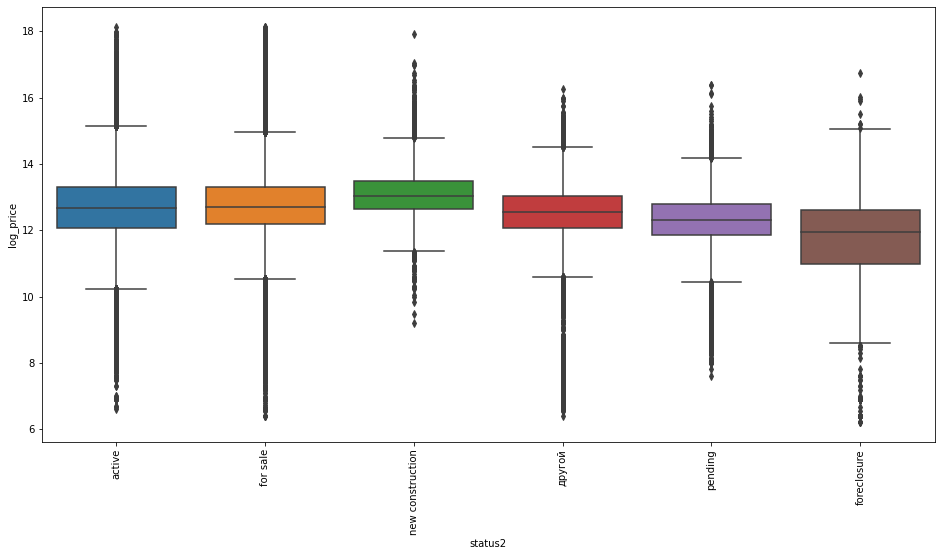

In [143]:
# Визуализируем
var = 'status2'
data_m = pd.concat([data['log_price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="log_price", data=data_m)
fig.axis();
plt.xticks(rotation=90);

In [144]:
# Уникальных значений
data.fireplace.nunique()

1254

In [145]:
#Посмотрим на наиболее популярные значения в признаке
data.fireplace.value_counts().head(20)

yes                 344230
1                    14882
no                    2664
2                     2432
gas                    832
ceiling fan            778
wood                   611
3                      597
family                 503
living                 442
gas great              303
special features       279
gas living             254
yes features           239
family gas             237
great                  207
family wood            205
living wood            186
4                      184
gas family             163
Name: fireplace, dtype: int64

Введем следующие бинарные признаки:

по наличию:
-no_fire (yes будет автоматически остальные)
1 не будем выделять - его можно считать yes без указания деталей
-2_fire
-fire_more3: если указано количество больше 3

По типу (встречающееся слово в уточнении:
-gas
-wood
-air
-electric

По расположению:
-ceiling
-living
-family
-great

Для оптимизации кода обработку этого признака можно сократить - так как мы ищем просто совпадение слов в описании признака. 

In [330]:
data['no_fire'] = data.fireplace.apply(lambda x: 0 if 'no' in x else 1)
data['2_fire'] = data.fireplace.apply(lambda x: 1 if x == '2' else 0)
num = ['5', '3', '4', '6']
data['fire_more3'] = data.fireplace.apply(lambda x: 1 if x in num else 0)

In [331]:
data['gas'] = data.fireplace.apply(lambda x: 1 if 'gas' in x else 0)
data['wood'] = data.fireplace.apply(lambda x: 1 if 'wood' in x else 0)
data['air'] = data.fireplace.apply(lambda x: 1 if 'air' in x else 0)
data['electric'] = data.fireplace.apply(lambda x: 1 if 'electric' in x else 0)

In [332]:
data['ceiling'] = data.fireplace.apply(lambda x: 1 if 'ceiling' in x else 0)
data['living'] = data.fireplace.apply(lambda x: 1 if 'living' in x else 0)
data['family'] = data.fireplace.apply(lambda x: 1 if 'family' in x else 0)
data['great'] = data.fireplace.apply(lambda x: 1 if 'great' in x else 0)

Расположение - Возможно living, great и family  описывают большую гостинную. и можно попробовать добавить признак общий, где укаазано хоть одно из трех слов

In [333]:
data['fireplace'] = data['fireplace'].apply(lambda x: x.replace('great', 'family').replace('living', 'family'))
data['great_family'] = data.fireplace.apply(lambda x: 1 if 'family' in x else 0)
#а признаки great, living можно удалять

In [334]:
#Итак, мы ввели следующие бинарные признаки:
new_binary = ['no_fire', '2_fire', 'fire_more3', 'gas', 'wood', 'air',
       'electric', 'ceiling', 'living', 'family', 'great', 'great_family']
        
#Исходный 'fireplace' можно удалять

In [151]:
for i in new_binary:
    print (i, data[i].value_counts()*100/len(data))

no_fire 1    99.244427
0     0.755573
Name: no_fire, dtype: float64
2_fire 0    99.350687
1     0.649313
Name: 2_fire, dtype: float64
fire_more3 0    99.764784
1     0.235216
Name: fire_more3, dtype: float64
gas 0    99.143506
1     0.856494
Name: gas, dtype: float64
wood 0    99.449473
1     0.550527
Name: wood, dtype: float64
air 0    99.926045
1     0.073955
Name: air, dtype: float64
electric 0    99.944467
1     0.055533
Name: electric, dtype: float64
ceiling 0    99.642504
1     0.357496
Name: ceiling, dtype: float64
living 0    99.567481
1     0.432519
Name: living, dtype: float64
family 0    99.525831
1     0.474169
Name: family, dtype: float64
great 0    99.767721
1     0.232279
Name: great, dtype: float64
great_family 0    98.937392
1     1.062608
Name: great_family, dtype: float64


air встречается только в 0.07 %. electric в 0.05%. ceiling 0.35%.great - 0.23% famiy, living - 0.47, 0.43%. Удалим их

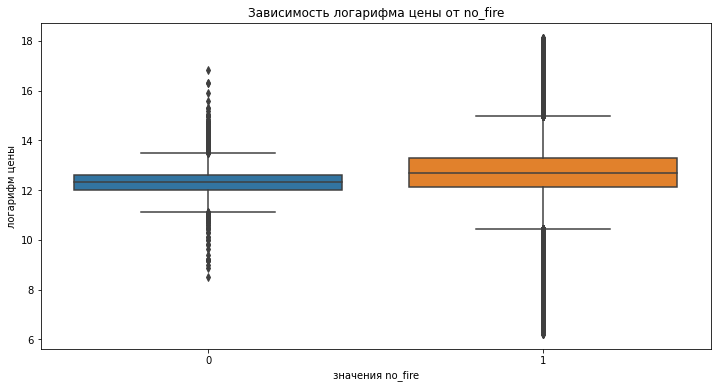

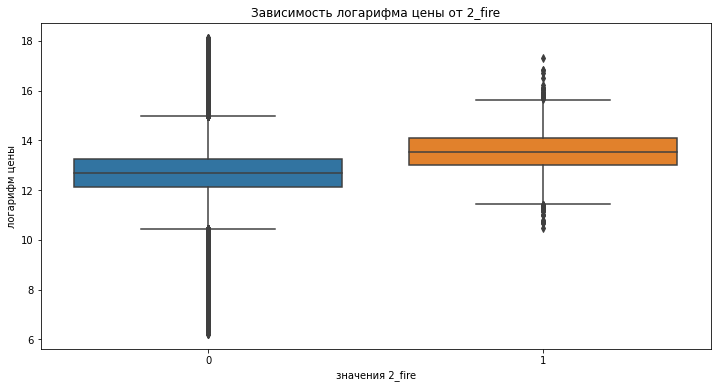

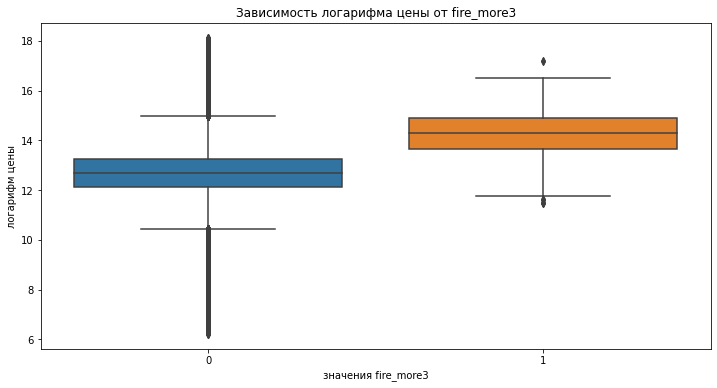

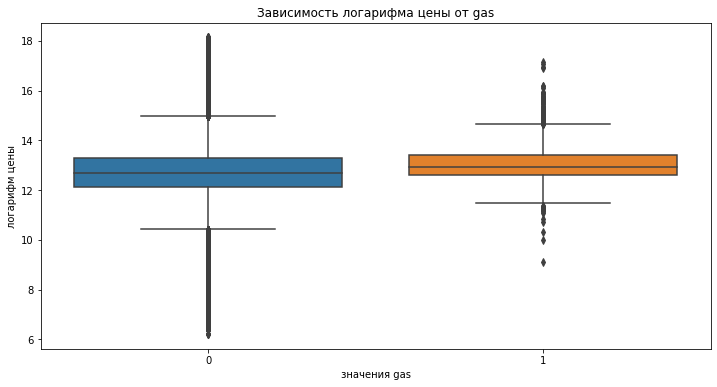

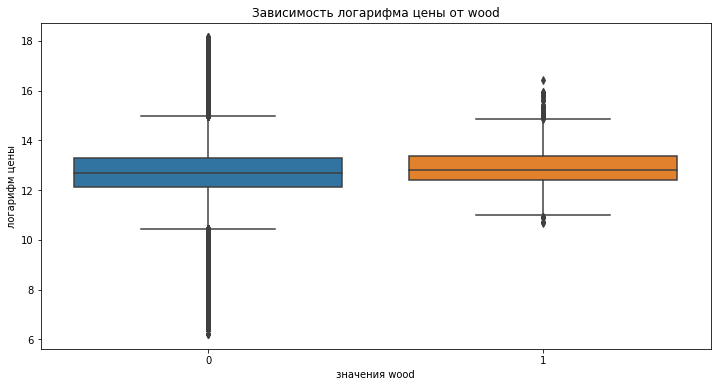

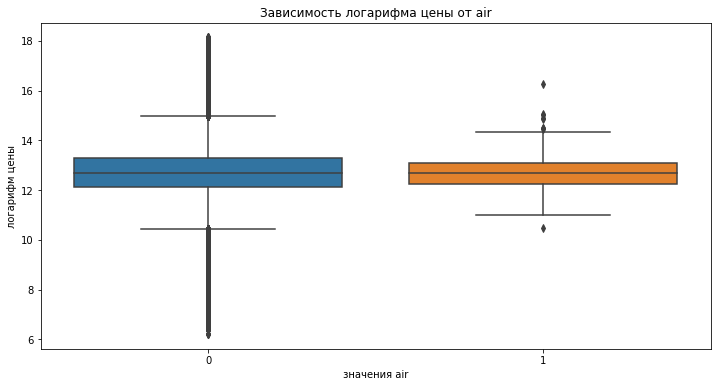

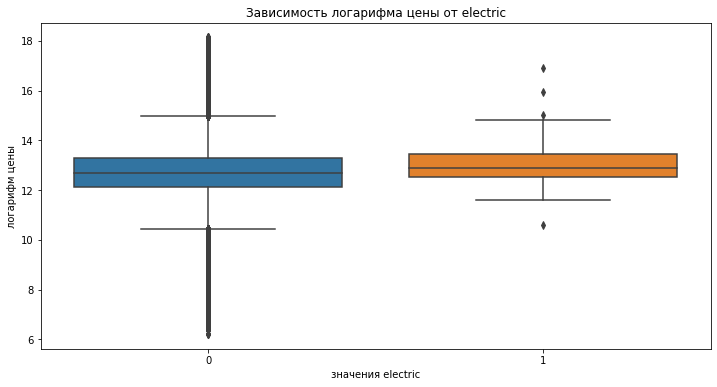

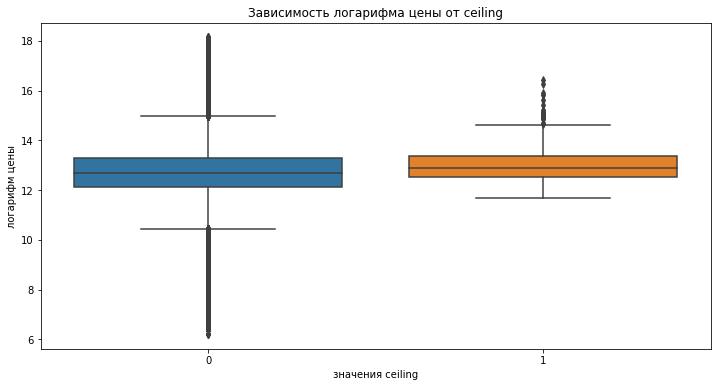

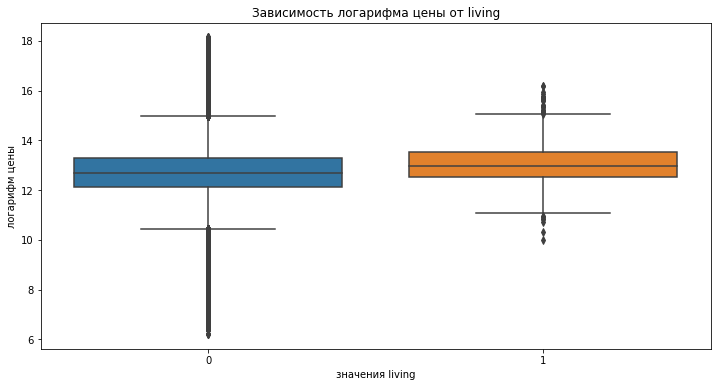

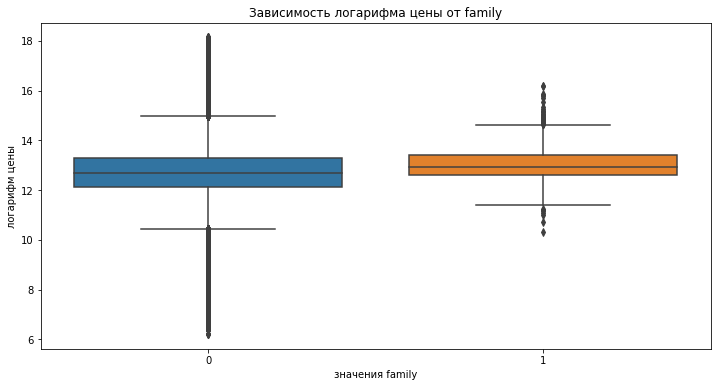

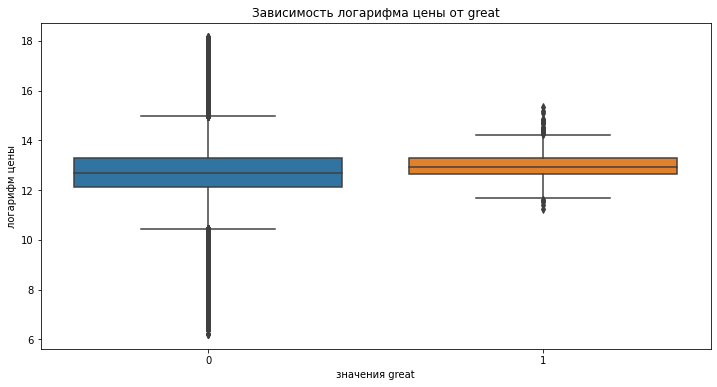

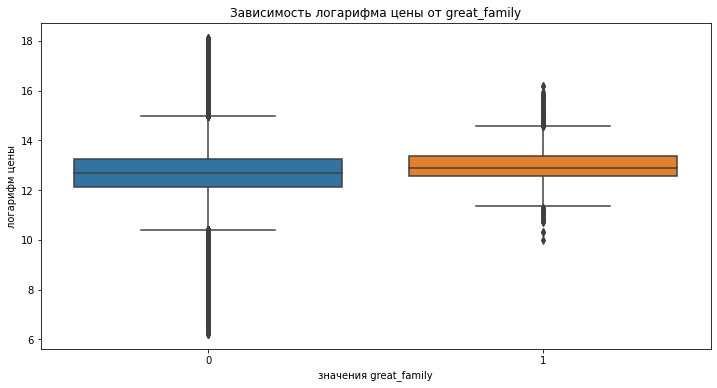

In [152]:
for i in new_binary:
    graf_cat(i)

Можно отметить, что количество указанных каминов (обогревателей) увеличивает стоимость жилья. что и логично - в объявлении указать максимум достоинств.
Источники газ и электричество тоже дает цену выше, тогда как остальные источники тепла выглядят на одном уровне.
Удалим сразу wood, air.


In [335]:
data['state2'] = data.state
state = data.state2.value_counts()[:16]
# Выделим 14 основных, остальные заменим общим типом "другой"
data['state2'] = data['state2'].apply(lambda x: x if x in state else 'другой')

In [154]:
data.state2.nunique()

17

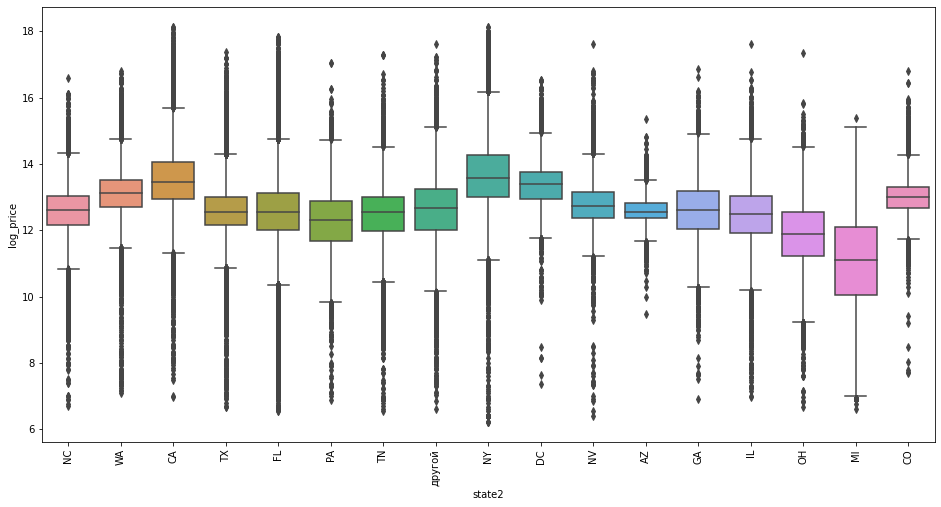

In [155]:
# Визуализируем
var = 'state2'
data_m = pd.concat([data['log_price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="log_price", data=data_m)
fig.axis();
plt.xticks(rotation=90);

In [156]:
# Посмотрим на наличие выбросов
outliers('sqft')

выбросы выше 4440.0


In [157]:
data[data.sqft > 4440]

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,mls-id,target,Pool,Year_built,count_school,average_raiting_school,max_rating,min_rating,average_distance_school,max_distance,min_distance,No_school,Elementary,Middle,High,Private,Air Base,Hope,Media Arts,East,Liberty,Harns,Nyc Lab,Myakka,no_parking,attached garage,detached garage,3_garage,5_garage,log_price,city2,drive,road,lane,trail,hwy,ave,propertyType2,status2,no_fire,2_fire,fire_more3,gas,wood,air,electric,ceiling,living,family,great,great_family,state2
3,for sale,single family,0,8,yes,Dallas,6457,75205,5,TX,3,0,2395000,0,2006,4,9.250000,10,9,0.752500,1.05,0.10,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,14.688894,Dallas,0,0,0,0,0,1,single family,for sale,1,0,0,0,0,0,0,0,0,0,0,0,TX
21,for sale,single family,0,5,yes,Bend,5266,97702,5,OR,1,201909438,3500000,0,2008,3,6.333333,8,5,4.666667,6.20,3.70,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15.068274,другой,0,1,0,0,0,0,single family,for sale,1,0,0,0,0,0,0,0,0,0,0,0,другой
25,for sale,single family,1,7,yes,Washington,5796,20009,8,DC,3,0,3749000,0,1915,2,6.500000,10,3,0.520000,0.90,0.14,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15.137000,Washington,0,0,0,0,0,0,single family,for sale,1,0,0,0,0,0,0,0,0,0,0,0,DC
46,for sale,single family,0,5,yes,Tyler,5358,75709,5,TX,2,10114247,1429000,0,2005,3,3.666667,5,2,2.666667,3.50,1.70,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,14.172485,другой,1,0,0,0,0,0,single family,for sale,1,0,0,0,0,0,0,0,0,0,0,0,TX
74,active,single family,0,2,yes,Kissimmee,5131,34746,5,FL,2,0,414900,0,2007,8,3.750000,7,2,2.837500,3.90,0.60,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,12.935793,другой,0,0,0,0,0,0,single family,active,1,0,0,0,0,0,0,0,0,0,0,0,FL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374437,for sale,coop,1,2,yes,Woodside,409538,11377,3,NY,1,0,335000,0,1931,3,4.666667,8,3,1.070000,1.48,0.25,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.721886,другой,0,0,0,0,0,0,coop,for sale,1,0,0,0,0,0,0,0,0,0,0,0,NY
374476,active,single family,0,2,yes,Brooklyn,4860,11219,3,NY,3,0,2199000,0,1920,3,6.000000,7,4,0.466667,0.80,0.30,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.603513,Brooklyn,0,0,0,0,0,1,single family,active,1,0,0,0,0,0,0,0,0,0,0,0,NY
374479,for sale,single family,0,4,yes,Arvada,4615,80007,4,CO,2,7690588,685000,0,2016,3,7.000000,8,6,3.866667,5.40,3.00,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,13.437174,другой,0,0,0,0,0,1,single family,for sale,1,0,0,0,0,0,0,0,0,0,0,0,CO
374533,for sale,single family,0,5,yes,Bonita Springs,5992,34134,4,FL,1,0,2495000,1,2006,24,5.458333,8,2,10.603750,17.13,2.06,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,14.729799,другой,0,0,0,0,0,0,single family,for sale,1,0,0,0,0,0,0,0,0,0,0,0,FL


In [158]:
data.sqft.describe()

count    3.745500e+05
mean     7.093322e+03
std      1.501716e+06
min      0.000000e+00
25%      1.200000e+03
50%      1.677000e+03
75%      2.496000e+03
max      7.959794e+08
Name: sqft, dtype: float64

In [336]:
data['log_sqft'] = np.log(data.sqft+1)

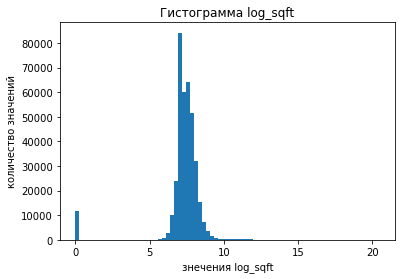

In [161]:
gistogramma('log_sqft')

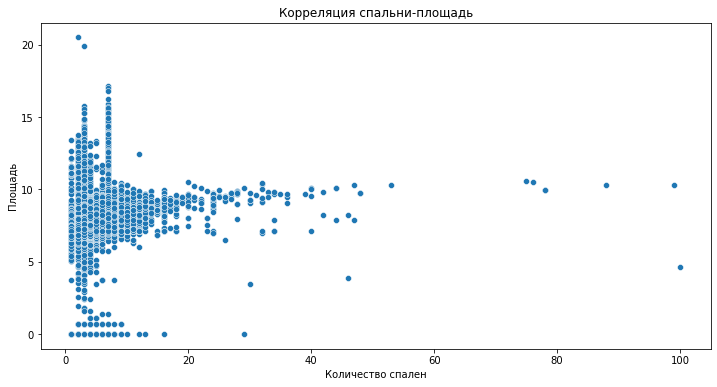

In [162]:
# look at the beds & baths outlier correlation
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='beds', y='log_sqft')
plt.xlabel(
    'Количество спален')
plt.ylabel(
    'Площадь')
plt.title('Корреляция спальни-площадь', fontsize=12)
plt.show()

In [337]:
#Удалим выбросы 
data = data.drop(data[data['log_sqft'] > 17].index).reset_index(drop=True)

In [338]:
data.loc[(data.log_sqft ==0), 'log_sqft'] = 8.7

In [339]:
cols = ['status','sqft', 'propertyType', 'fireplace', 'city', 'state', 'zipcode', 'mls-id', 'living', 'great', 'family', 'drive', 'ave', 
        'hwy', 'street', 'wood', 'air', 'electric', 'ceiling', 'lane']

In [340]:
data = data.drop(cols, axis=1)

In [341]:
data.loc[(data.max_distance > 130), 'max_distance'] = 130
data.loc[(data.average_distance_school > 130), 'min_distance'] = 130
data.loc[(data.average_distance_school > 130), 'average_distance_school'] = 130

In [102]:
numeric_columns = ['baths', 'log_sqft', 'beds', 'stories', 
       'Year_built', 'count_school',
       'average_raiting_school', 'max_rating', 'min_rating', 'average_distance_school', 'max_distance',
       'min_distance', 'log_price']

In [173]:
data[numeric_columns].corr()

,baths,log_sqft,beds,stories,Year_built,count_school,average_raiting_school,max_rating,min_rating,average_distance_school,max_distance,min_distance
baths,1.000000,0.312554,0.525143,0.087328,0.025828,-0.059742,0.146692,0.081825,0.155049,-0.035675,-0.042734,-0.007744
log_sqft,0.312554,1.000000,0.448584,0.043094,0.143142,0.003709,0.164912,0.120031,0.143106,-0.012525,-0.045227,0.054672
beds,0.525143,0.448584,1.000000,-0.001087,-0.018125,-0.011150,0.062492,0.019947,0.086581,-0.048755,-0.061431,-0.001608
stories,0.087328,0.043094,-0.001087,1.000000,-0.009637,-0.010262,0.042365,0.030913,0.005106,-0.055649,-0.053700,-0.029527
Year_built,0.025828,0.143142,-0.018125,-0.009637,1.000000,-0.020243,0.190055,0.155797,0.162804,0.137129,0.081251,0.164068
count_school,-0.059742,0.003709,-0.011150,-0.010262,-0.020243,1.000000,-0.094547,0.125804,-0.203905,0.141879,0.180620,-0.030416
average_raiting_school,0.146692,0.164912,0.062492,0.042365,0.190055,-0.094547,1.000000,0.833032,0.839911,0.152862,0.135066,0.091075
max_rating,0.081825,0.120031,0.019947,0.030913,0.155797,0.125804,0.833032,1.000000,0.488456,0.301736,0.363256,0.042636
min_rating,0.155049,0.143106,0.086581,0.005106,0.162804,-0.203905,0.839911,0.488456,1.000000,-0.009252,-0.076845,0.102859
average_distance_school,-0.035675,-0.012525,-0.048755,-0.055649,0.137129,0.141879,0.152862,0.301736,-0.009252,1.000000,0.916528,0.642220


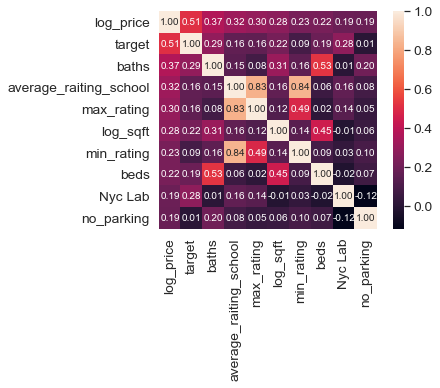

In [174]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
corrmat = data.corr()
cols = corrmat.nlargest(k, 'log_price')['log_price'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [175]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,log_price
1,target
2,baths
3,average_raiting_school
4,max_rating
5,log_sqft
6,min_rating
7,beds
8,Nyc Lab
9,no_parking


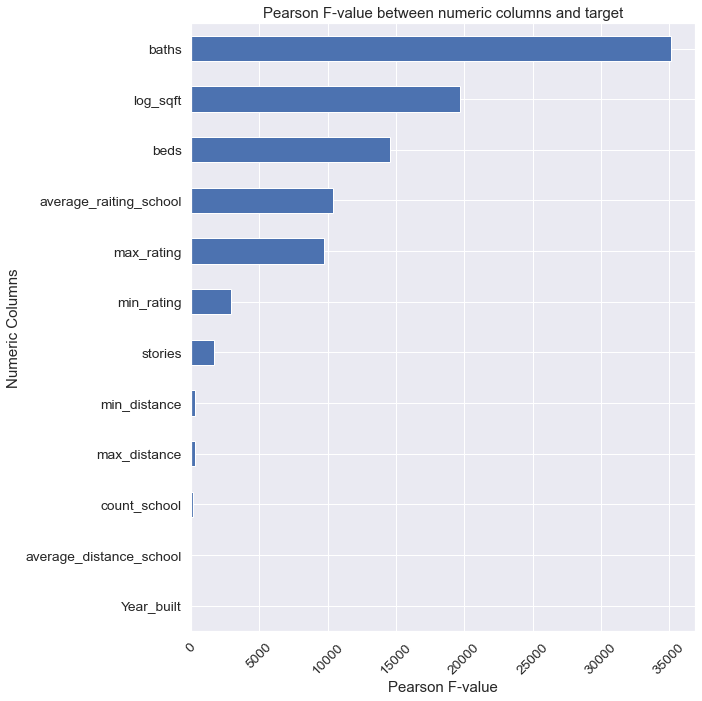

In [176]:
# calculate Pearson's F-value for numerical columns and plot the result
pearson = pd.Series(f_regression(data[numeric_columns], data['target'])[0], index = numeric_columns)
pearson.sort_values(inplace = True)
plt.figure(figsize=(10, 10))
pearson.plot(kind='barh')
plt.ylabel('Numeric Columns')
plt.xlabel('Pearson F-value')
plt.title("Pearson F-value between numeric columns and target")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [177]:
bynary_columns = ['Pool', 'No_school', 'Elementary', 'Middle', 'High',
       'Private', 'Air Base', 'Hope', 'Media Arts', 'East', 'Liberty', 'Harns',
       'Nyc Lab', 'Myakka', 'no_parking', 'attached garage', 'detached garage', 
       '3_garage', '5_garage', 'city2',  'road', 'trail',
       'no_fire', '2_fire', 'fire_more3', 'gas']

In [178]:
for col in bynary_columns:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки Pool
Найдены статистически значимые различия для колонки No_school
Найдены статистически значимые различия для колонки Elementary
Найдены статистически значимые различия для колонки Middle
Найдены статистически значимые различия для колонки High
Найдены статистически значимые различия для колонки Private
Найдены статистически значимые различия для колонки Air Base
Найдены статистически значимые различия для колонки Hope
Найдены статистически значимые различия для колонки Media Arts
Найдены статистически значимые различия для колонки East
Найдены статистически значимые различия для колонки Liberty
Найдены статистически значимые различия для колонки Harns
Найдены статистически значимые различия для колонки Nyc Lab
Найдены статистически значимые различия для колонки Myakka
Найдены статистически значимые различия для колонки no_parking
Найдены статистически значимые различия для колонки attached garage
Найдены статистически значимые разли

In [343]:
categorial_columns = ['status2', 'propertyType2', 'city2', 'state2']
for col in categorial_columns:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки status2
Найдены статистически значимые различия для колонки propertyType2
Найдены статистически значимые различия для колонки city2
Найдены статистически значимые различия для колонки state2


In [344]:
# Удалим target
data.drop(['target'], axis=1, inplace=True)


In [180]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374547 entries, 0 to 374546
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   baths                    374547 non-null  int32  
 1   beds                     374547 non-null  int64  
 2   stories                  374547 non-null  int32  
 3   Pool                     374547 non-null  int32  
 4   Year_built               374547 non-null  int64  
 5   count_school             374547 non-null  int64  
 6   average_raiting_school   374547 non-null  float64
 7   max_rating               374547 non-null  int32  
 8   min_rating               374547 non-null  int32  
 9   average_distance_school  374547 non-null  float64
 10  max_distance             374547 non-null  float64
 11  min_distance             374547 non-null  float64
 12  No_school                374547 non-null  int64  
 13  Elementary               374547 non-null  int64  
 14  Midd

### ML

In [345]:
def print_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

In [367]:
train_df = data.copy(deep=True)

In [368]:

#Преобразуем не числовые данные
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))

#### Baseline

In [369]:
train_X = train_df.drop(["log_price"], axis=1)
train_Y = train_df["log_price"]

In [217]:
scaler = StandardScaler()
scaler.fit(train_X)

StandardScaler()

In [218]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(train_X, train_Y, test_size=0.4)

In [223]:
print('LinearRegression')
model = LinearRegression()
model.fit(Xtrain, Ytrain)
y_pred = model.predict(Xtest)
# метрики
print_metrics(Ytest, y_pred)

LinearRegression
MSE = 0.84, RMSE = 0.92


In [224]:
Xtrain

,baths,beds,stories,Pool,Year_built,count_school,average_raiting_school,max_rating,min_rating,average_distance_school,max_distance,min_distance,No_school,Elementary,Middle,High,Private,Air Base,Hope,Media Arts,East,Liberty,Harns,Nyc Lab,Myakka,no_parking,attached garage,detached garage,3_garage,5_garage,city2,road,trail,propertyType2,status2,no_fire,2_fire,fire_more3,gas,great_family,state2,log_sqft
104590,3,3,1,1,1975,3,4.333333,7,3,1.116667,1.19,1.03,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,11,0,0,6,1,1,0,0,0,0,9,7.759614
296434,2,3,4,0,2019,2,4.500000,6,3,0.500000,0.60,0.40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,0,0,0,0,10,7.090077
357859,2,3,1,0,2019,3,4.666667,7,3,1.233333,1.90,0.70,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,22,0,0,6,3,1,0,0,0,0,1,7.549083
28481,1,1,1,0,1967,3,4.000000,5,2,1.700000,2.30,1.10,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,9,1,0,7,1,1,0,0,0,0,14,6.608001
57529,2,2,3,0,2019,1,6.000000,6,6,4.600000,4.60,4.60,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,6,1,1,0,0,0,0,4,7.688913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39373,1,2,2,0,1974,3,6.333333,7,6,2.900000,4.80,0.60,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,6,1,1,0,0,0,0,14,7.404279
27560,2,3,1,0,1949,4,4.750000,6,4,1.375000,1.80,0.60,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,22,0,0,5,0,1,0,1,0,0,11,7.090910
205487,1,3,2,0,1935,8,5.500000,9,3,2.025000,4.80,0.30,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,22,0,0,6,0,1,0,0,0,0,11,7.271704
193863,2,3,1,0,1989,3,4.333333,5,3,3.966667,4.70,3.00,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,22,1,0,5,0,1,0,0,0,0,10,7.321850


In [220]:
print('RandomForestRegression')
model2 = RandomForestRegressor(max_depth=10, random_state=random_seed)
model2.fit(Xtrain, Ytrain)
y_pred = model2.predict(X_valid)
# метрики
print_metrics(Ytest, y_pred)

RandomForestRegression
MSE = 2.28, RMSE = 1.51


<AxesSubplot:>

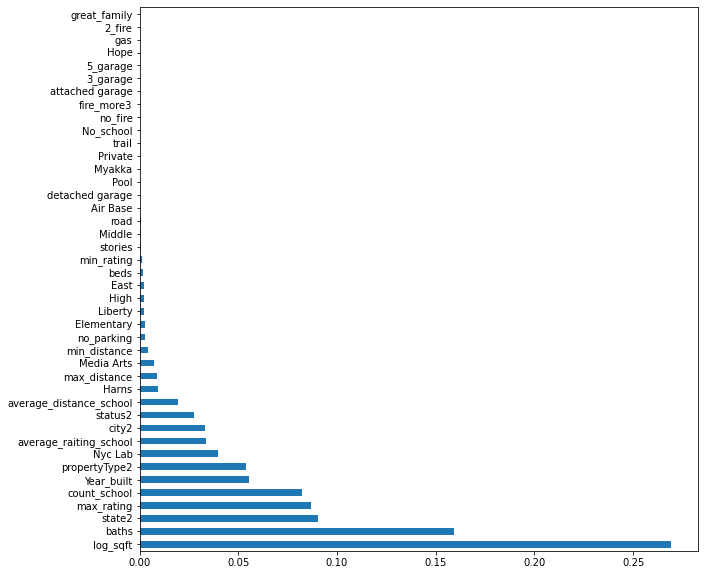

In [221]:
#  Выведем наиболее значимые признаки
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model2.feature_importances_, index=train_X.columns)
feat_importances.nlargest(70).plot(kind='barh')

In [351]:
cols = ['great_family', 'gas', 'Hope', '3_garage', 'attached garage', 'No_school', 'Private', 'detached garage', 
        'road', 'trail', 'Air Base', 'Middle', 'Myakka']

train_df = train_df.drop(cols, axis=1)

In [353]:

#Преобразуем не числовые данные
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))

In [354]:
train_X = train_df.drop(["log_price"], axis=1)
train_Y = train_df["log_price"]

In [355]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(train_X, train_Y, test_size=0.4)

In [356]:
#Другая нормализация данных
scaler = MinMaxScaler()
scaler.fit(train_X)

MinMaxScaler()

In [358]:
print('LinearRegression')
model = LinearRegression()
model.fit(Xtrain, Ytrain)
y_pred = model.predict(Xtest)
# метрики
print_metrics(Ytest, y_pred)

LinearRegression
MSE = 0.86, RMSE = 0.93


In [359]:
print('RandomForestRegression')
model = RandomForestRegressor(max_depth=10, random_state=random_seed)
model.fit(Xtrain, Ytrain)
y_pred = model.predict(Xtest)
# метрики
print_metrics(Ytest, y_pred)

RandomForestRegression
MSE = 0.52, RMSE = 0.72


<AxesSubplot:>

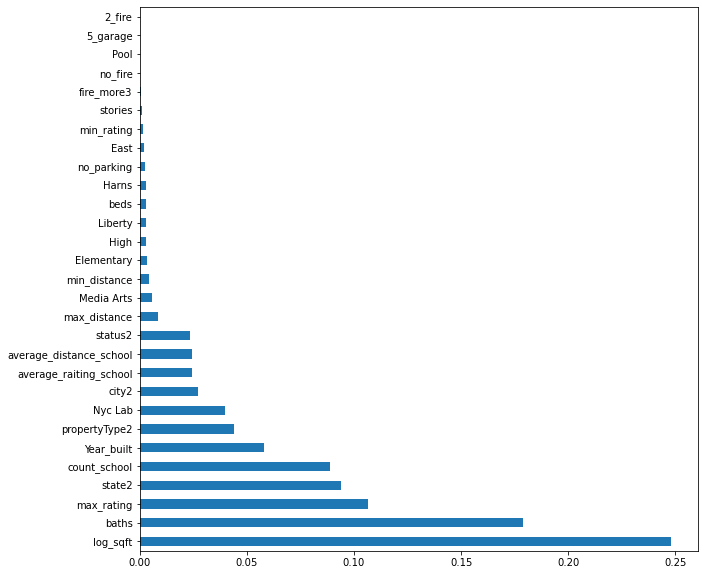

In [360]:
#  Выведем наиболее значимые признаки
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=train_X.columns)
feat_importances.nlargest(70).plot(kind='barh')

#### Линейная регрессия с использованием методов оптимизации

In [ ]:
train_df = data.copy(deep=True)

#Преобразуем не числовые данные
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))
        
train_X = train_df.drop(["log_price"], axis=1)
train_Y = train_df["log_price"]

In [361]:
# функция вычисления градиента функции MSE

def calc_mse_gradient(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
    
    return grad

# функцяю, осуществляющая градиентный шаг: параметр величины шага alpha - learning rate)

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad

# функция цикла градиентного спуска с доп. параметрами начального вектора theta и числа итераций

def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta

In [375]:
# Разобьем таблицу данных и добавим фиктивный столбец единиц (bias линейной модели)
X, y = train_X, train_Y
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [376]:
# Оптимизируем параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.001, 100)

In [377]:
# Нормализуем даннные с помощью стандартной нормализации
X, y = train_X, train_Y
X = (X - X.mean(axis=0)) / X.std(axis=0)
# Добавим фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

In [373]:
# Оптимизируем theta
#theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.01, 1000)

In [378]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4)
theta = optimize(X_train, y_train, calc_mse_gradient, np.ones(m), 0.001, 5000)
y_pred = X_valid.dot(theta)

print_metrics(y_valid, y_pred)

MSE = 0.90, RMSE = 0.95


#### RandomForestRegressor

In [379]:
train_df = data.copy(deep=True)
#Преобразуем не числовые данные
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))


cols = ['great_family', 'gas', 'Hope', '3_garage', 'attached garage', 'No_school', 'Private', 'detached garage', 
        'road', 'trail', 'Air Base', 'Middle', 'Myakka']

train_df = train_df.drop(cols, axis=1)

train_X = train_df.drop(["log_price"], axis=1)
train_Y = train_df["log_price"]



In [380]:
train_df = pd.get_dummies(train_df, columns=[ 'status2','city2','propertyType2', 'state2'], dummy_na=True)  

Xtrain,Xtest,Ytrain,Ytest = train_test_split(train_X, train_Y, test_size=0.4)

In [382]:
#Организуем обучение в цикле для Random Forest
gr=np.arange(1,15,1)
facc=[]
acc=0
for i in gr:
    scc=0
    model = RandomForestRegressor(n_estimators=i, max_depth = 15)
    model.fit(Xtrain,Ytrain)
    y_predicted = model.predict(Xtest)
    scc=model.score(Xtest,Ytest)
    facc.append(scc)
    if scc > acc:
        acc=scc
        mf=i
        print("Random Forest: , n_estimators", i, " Точность", scc)

Random Forest: , n_estimators 1  Точность 0.6423524767080491
Random Forest: , n_estimators 2  Точность 0.6840963077797636
Random Forest: , n_estimators 3  Точность 0.6983923395527367
Random Forest: , n_estimators 4  Точность 0.7054458121690536
Random Forest: , n_estimators 5  Точность 0.7158586180473127
Random Forest: , n_estimators 8  Точность 0.7211707679216619
Random Forest: , n_estimators 10  Точность 0.7228657297237842
Random Forest: , n_estimators 11  Точность 0.7240928959643482
Random Forest: , n_estimators 12  Точность 0.7251388347062215


In [383]:
print_metrics(y_predicted, Ytest)

MSE = 0.40, RMSE = 0.63


best n_estimators 12 Наилучшая точность 0.7251388347062215
Error RMSLE 0.0024364219086830314


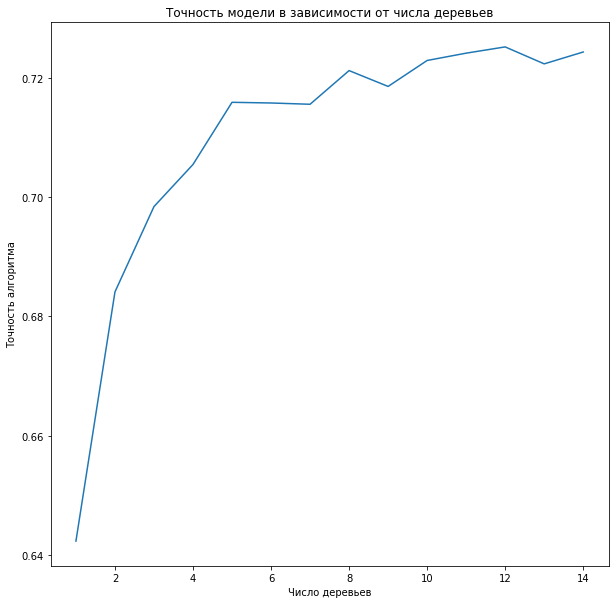

In [384]:
plt.plot(gr,facc)
plt.title("Точность модели в зависимости от числа деревьев")
plt.xlabel("Число деревьев")
plt.ylabel("Точность алгоритма")
print("best n_estimators", mf, "Наилучшая точность", acc )
scc=mean_squared_log_error(Ytest, y_predicted)
print("Error RMSLE", scc)

In [123]:
rf = RandomForestRegressor(random_state = 42)
# Look at parameters used by our current forest
print('Параметры по умолчанию:\n')
pprint(rf.get_params())

Параметры по умолчанию:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [124]:

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [125]:
rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=10, 
                               cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(Xtrain, Ytrain)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 86.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [126]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

In [391]:
y_pred = rf_random.predict(Xtest)

In [392]:
print_metrics(y_pred, Ytest)

MSE = 0.17, RMSE = 0.41


GradientBoostingRegressor c заданными параметрами


In [390]:
train_df = data.copy(deep=True)
#Преобразуем не числовые данные
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))


cols = ['great_family', 'gas', 'Hope', '3_garage', 'attached garage', 'No_school', 'Private', 'detached garage', 
        'road', 'trail', 'Air Base', 'Middle', 'Myakka']

train_df = train_df.drop(cols, axis=1)

train_X = train_df.drop(["log_price"], axis=1)
train_Y = train_df["log_price"]


Xtrain,Xtest,Ytrain,Ytest = train_test_split(train_X, train_Y, test_size=0.4)

In [387]:
model1 = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [388]:
model1.fit(Xtrain, Ytrain)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=3000,
                          random_state=5)

In [389]:
y_pred = model1.predict(Xtest)
print_metrics(y_pred, Ytest)

MSE = 0.38, RMSE = 0.62


In [202]:
bagging_gbr = BaggingRegressor(GradientBoostingRegressor(random_state=random_seed\
                                                         , n_estimators=300\
                                                        , min_samples_split=5\
                                                        , min_samples_leaf=17\
                                                        , max_features='auto'\
                                                        , max_depth=8\
                                                        , learning_rate=0.13428571428571429)\
                                 , random_state=random_seed\
                                 , n_jobs=-1)



KeyboardInterrupt: 

In [ ]:
bagging_gbr.fit(Xtrain, Ytrain)

y_pred = bagging_gbr.predict(Xtest)
# # look at metrics
print_metrics(Ytest, y_pred)

Результаты:

 нормализация: StandardScaler()
        LinearRegression MSE = 0.84, RMSE = 0.92 
        RandomForestRegressor MSE = 2.28, RMSE = 1.51 

нормализация MinMaxScaler()
        LinearRegression MSE = 0.86, RMSE = 0.93
        RandomForestRegression MSE = 0.52, RMSE = 0.72

        Линейная регрессия с использованием методов оптимизации MSE = 0.90, RMSE = 0.95
        RandomForestRegressor c get_dummies MSE = 0.40, RMSE = 0.63

       
        GradientBoostingRegressor MSE = 0.38, RMSE = 0.62
 
        Randomize(RandomForestRegressor) MSE = 0.17, RMSE = 0.41
